## Imports

In [1]:
#Reg Default imports
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import itertools
from collections import Counter
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Curve fitter import
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

#Model and Statistic imports
from ta import add_all_ta_features
from ta.utils import dropna
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.neural_network import MLPClassifier
import researchpy as rp
import scipy.stats as stats
from sklearn.model_selection import train_test_split

## DB initialization

In [2]:
#Varied list of Stocks
stocks = ["PLD","EQIX","O","NKE","LULU","TJX","TSM","NVDA",
          "TSLA","MGM","MAR","SBUX","EBAY","AMZN","AAPL",
         "JPM","BAC","SCHW","JNJ","ABBV","NVS","AMGN",
         "XOM","SU","D","NEE","XEL","SPWR","LMT","TDG","MRCY",
         "FC","AWK","WTRG","CAJ","PWR","STN","LUV","DAL","GPK",
         "GLW","INTU","CSCO"]

In [3]:
%%capture
# Creation of data, closing price of stock is retrieved
stock_list = []
for stock in stocks:
    df = yf.download(stock , period="10y", interval="1d");
    df.dropna(inplace=True);
    stock_list.append(df['Adj Close']);

data = pd.concat(stock_list, axis = 1)
data.columns = stocks

In [4]:
# Creation of daily percent changes data 1.0 = 0 % change
data_percentage = data.pct_change()

data_percentage = data_percentage.fillna(0)

data_percentage = data_percentage + 1

# Preserving Day of Week Data
dayofweek = []
for x in data_percentage.index:
    t = pd.Timestamp(x)
    dayofweek.append(t.date().weekday())
data_percentage.insert(len(data_percentage.columns),"day", dayofweek, True)

## Profitability Tests

#### Buying and Holding 

In [5]:
#DB initialization
data_bh = pd.DataFrame()

In [6]:
# Prof Simulator
def BH(stocks):
    for x in stocks:
        Totals = []
        StartSum = 10000
        for i,n in enumerate(data_percentage[x]):
            StartSum = StartSum * (data_percentage[x].iloc[i])
            Totals.append(StartSum)
        data_bh.insert(len(data_bh.columns),"{} Buy & Hold".format(x), Totals, True)

In [7]:
#Function Call
BH(stocks)

In [8]:
#Calcuation of percent yields
#An investment of $100 ending an amount of $400 has a 300% positive yield
bhyields = list(((data_bh.iloc[-1].values -data_bh.iloc[0].values) / data_bh.iloc[0].values)*100)

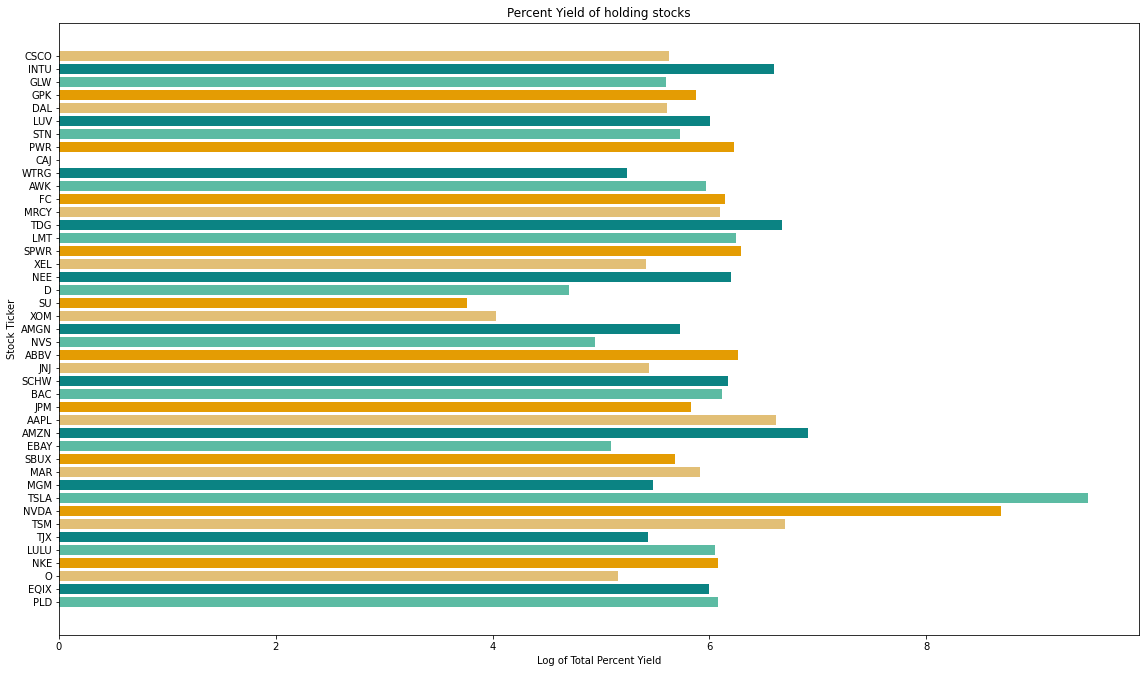

In [9]:
#Plotting Out Total percent Yields
plt.rcParams["figure.figsize"] = (15,8.5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(stocks,np.log(bhyields),color=['#5CBBA3','#0B8383','#E2BF76','#E49C03'])
plt.xlabel('Log of Total Percent Yield')
plt.ylabel('Stock Ticker')
plt.title('Percent Yield of holding stocks')
plt.show()

#### Perfect Stock Scalping

In [10]:
#DB initialization
max_value_stocks = pd.DataFrame()
#Max val function
def max_values(stocks):
    for x in stocks:
        Totals = []
        StartSum = 10000
        for i,n in enumerate(data_percentage[x]):
            if n >= 1:
                StartSum = StartSum * (data_percentage[x].iloc[i])
                Totals.append(StartSum)
            else:
                Totals.append(StartSum)
        max_value_stocks.insert(len(max_value_stocks.columns),"{} Max_value".format(x), Totals, True)

In [11]:
#Function Call and Yield Calculations
max_values(stocks)
yields = []
for s in stocks: 
    yields.append(((max_value_stocks[str(s)+' Max_value'].iloc[-1] -max_value_stocks[str(s)+' Max_value'].iloc[0]) / max_value_stocks[str(s)+' Max_value'].iloc[0]) * 100)

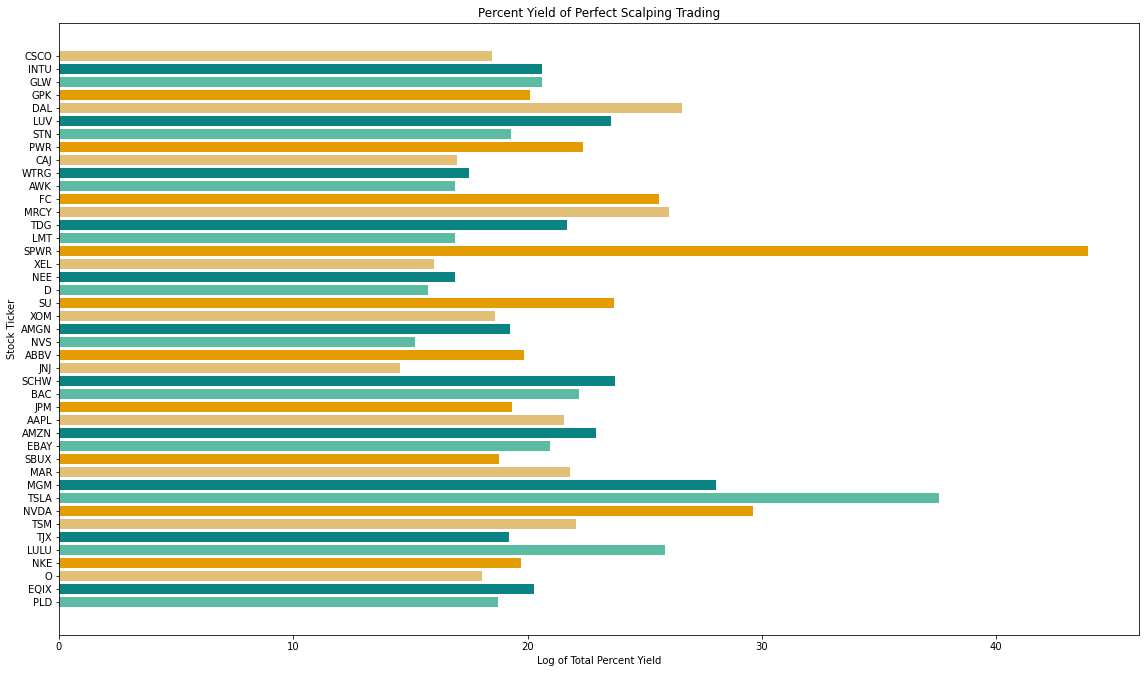

In [12]:
plt.rcParams["figure.figsize"] = (15,8.5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(stocks,np.log(yields),color=['#5CBBA3','#0B8383','#E2BF76','#E49C03'])
plt.xlabel('Log of Total Percent Yield')
plt.ylabel('Stock Ticker')
plt.title('Percent Yield of Perfect Scalping Trading')
plt.show()

## HMACM Creation

#### Helper Functions

##### Pct_Change +/-

In [13]:
def incdec (row):
    if row['pct_change'] < 0:
        return(-1)
    elif row['pct_change'] > 0:
        return(1)
    else:
        return(0)
    
def incdec10 (row):
    if row['pct_change support'] < 0:
        return(-1)
    elif row['pct_change support'] > 0:
        return(1)
    else:
        return(0)
    
def incdec2 (row):
    if row['underlying_stock_pct_change'] < 1:
        return(-1)
    elif row['underlying_stock_pct_change'] > 1:
        return(1)
    else:
        return(0)
    
def incdec3 (row):
    if row['overall_underlying_pct_change_in_phase'] < 1:
        return(-1)
    elif row['overall_underlying_pct_change_in_phase'] > 1:
        return(1)
    else:
        return(0)
    
def incdec13 (row):
    if row['overall_underlying_pct_change_in_phase support'] < 1:
        return(-1)
    elif row['overall_underlying_pct_change_in_phase support'] > 1:
        return(1)
    else:
        return(0)

##### Phase traits

In [14]:
def phase_one (row):
    if row['phase'] == 1:
        return(1)
    else:
        return(0)
def phase_two (row):
    if row['phase'] == 2:
        return(1)
    else:
        return(0)
def phase_three (row):
    if row['phase'] == 3:
        return(1)
    else:
        return(0)
def phase_four (row):
    if row['phase'] == 4:
        return(1)
    else:
        return(0)
def phase_one_pos (row):
    if row['phase'] == 1 and row['overall U.S. phase +/-'] == 1:
        return(1)
    else:
        return(0)
def phase_two_pos (row):
    if row['phase'] == 2 and row['overall U.S. phase +/-'] == 1:
        return(1)
    else:
        return(0)
def phase_three_pos (row):
    if row['phase'] == 3 and row['overall U.S. phase +/-'] == 1:
        return(1)
    else:
        return(0)
def phase_four_pos (row):
    if row['phase'] == 4 and row['overall U.S. phase +/-'] == 1:
        return(1)
    else:
        return(0)
    
def phase_one_before_pos (row):
    if row['phase_before'] == 1 and row['overall U.S. phase +/-'] == 1:
        return(1)
    else:
        return(0)
def phase_two_before_pos (row):
    if row['phase_before'] == 2 and row['overall U.S. phase +/-'] == 1:
        return(1)
    else:
        return(0)
def phase_three_before_pos (row):
    if row['phase_before'] == 3 and row['overall U.S. phase +/-'] == 1:
        return(1)
    else:
        return(0)
def phase_four_before_pos (row):
    if row['phase_before'] == 4 and row['overall U.S. phase +/-'] == 1:
        return(1)
    else:
        return(0)
    
def phase_one_before (row):
    if row['phase_before'] == 1:
        return(1)
    else:
        return(0)
def phase_two_before (row):
    if row['phase_before'] == 2:
        return(1)
    else:
        return(0)
def phase_three_before (row):
    if row['phase_before'] == 3:
        return(1)
    else:
        return(0)
def phase_four_before (row):
    if row['phase_before'] == 4:
        return(1)
    else:
        return(0)
def phase_change(row):
    if row['phase_right_before'] != row['phase']:
        return(1)
    else:
        return(0)
    
    
def phase_one10 (row):
    if row['phase support'] == 1:
        return(1)
    else:
        return(0)
def phase_two10 (row):
    if row['phase support'] == 2:
        return(1)
    else:
        return(0)
def phase_three10 (row):
    if row['phase support'] == 3:
        return(1)
    else:
        return(0)
def phase_four10 (row):
    if row['phase support'] == 4:
        return(1)
    else:
        return(0)
def phase_one_pos10 (row):
    if row['phase support'] == 1 and row['overall U.S. phase +/- support'] == 1:
        return(1)
    else:
        return(0)
def phase_two_pos10 (row):
    if row['phase support'] == 2 and row['overall U.S. phase +/- support'] == 1:
        return(1)
    else:
        return(0)
def phase_three_pos10 (row):
    if row['phase support'] == 3 and row['overall U.S. phase +/- support'] == 1:
        return(1)
    else:
        return(0)
def phase_four_pos10 (row):
    if row['phase support'] == 4 and row['overall U.S. phase +/- support'] == 1:
        return(1)
    else:
        return(0)
    
def phase_one_before_pos10 (row):
    if row['phase_before support'] == 1 and row['overall U.S. phase +/- support'] == 1:
        return(1)
    else:
        return(0)
def phase_two_before_pos10 (row):
    if row['phase_before support'] == 2 and row['overall U.S. phase +/- support'] == 1:
        return(1)
    else:
        return(0)
def phase_three_before_pos10 (row):
    if row['phase_before support'] == 3 and row['overall U.S. phase +/- support'] == 1:
        return(1)
    else:
        return(0)
def phase_four_before_pos10 (row):
    if row['phase_before support'] == 4 and row['overall U.S. phase +/- support'] == 1:
        return(1)
    else:
        return(0)
    
def phase_one_before10 (row):
    if row['phase_before support'] == 1:
        return(1)
    else:
        return(0)
def phase_two_before10 (row):
    if row['phase_before support'] == 2:
        return(1)
    else:
        return(0)
def phase_three_before10 (row):
    if row['phase_before support'] == 3:
        return(1)
    else:
        return(0)
def phase_four_before10 (row):
    if row['phase_before support'] == 4:
        return(1)
    else:
        return(0)
def phase_change10(row):
    if row['phase_right_before support'] != row['phase support']:
        return(1)
    else:
        return(0)

#### Concavity Maker

In [15]:
def concavity_maker(stocks):
    
    dic = {}
    global data
     
    for s in stocks:
        
        temp = pd.DataFrame(data[s].copy())
        
        temp['MA_10'] = 0
        temp['MA_5'] = 0
        temp['MA_3'] = 0
        temp['MA_60'] = 0
        temp['MA_120'] = 0
        temp['MA_21'] = 0
        
        for i in range(1,22):
            temp['MA_21']+=temp[s].shift(i)
        for i in range(1,61):
            temp['MA_60']+=temp[s].shift(i)
        for i in range(1,121):
            temp['MA_120']+=temp[s].shift(i)
        for i in range(1,11):
            temp['MA_10']+=temp[s].shift(i)
        for i in range(1,6):
            temp['MA_5']+=temp[s].shift(i)
        for i in range(1,4):
            temp['MA_3']+=temp[s].shift(i)

        temp['MA_10'] = temp['MA_10']/10
        temp['MA_5'] = temp['MA_5']/5
        temp['MA_3'] = temp['MA_3']/3
        temp['MA_60'] = temp['MA_60']/60
        temp['MA_120'] = temp['MA_120']/120
        temp['MA_21'] = temp['MA_21']/21
        
        temp = temp.fillna(0)
        
        WMA_60 = []
        weights = list(range(60, 0, -1))
        for i,x in enumerate(temp[s][60:]):
            i += 60
            WA_entry = []
            for y,w in enumerate(weights):
                WA_entry.append(temp[s].iloc[i-y]*w)
            n = (60 * 61) / 2
            fin = np.sum(WA_entry) / n
            WMA_60.append(fin)

        WMA_30 = []
        weights = list(range(30, 0, -1))
        for i,x in enumerate(temp[s][60:]):
            i += 60
            WA_entry = []
            for y,w in enumerate(weights):
                WA_entry.append(temp[s].iloc[i-y]*w)
            n = (30 * 31) / 2
            fin = np.sum(WA_entry) / n
            WMA_30.append(fin)

        WMA_30_2 = list(map(lambda x: x * 2, WMA_30))
        
        difference_long = []
        WMAs_long = zip(WMA_30_2, WMA_60)
        for list1_i, list2_i in WMAs_long:
            difference_long.append(list1_i-list2_i)
        raw_hull_long = difference_long
        
        HMA_long = []
        weights_long = list(range(9, 0, -1))
        for i,x in enumerate(raw_hull_long[9:]):
            i += 9
            WA_entry = []
            for y,w in enumerate(weights_long):
                WA_entry.append(raw_hull_long[i-y]*w)
            n = (9 * 10) / 2
            fin = np.sum(WA_entry) / n
            HMA_long.append(fin)
        
        WMA_10 = []
        weights = list(range(10, 0, -1))
        for i,x in enumerate(temp[s][10:]):
            i += 10
            WA_entry = []
            for y,w in enumerate(weights):
                WA_entry.append(temp[s].iloc[i-y]*w)
                n = (10 * 11) / 2
            fin = np.sum(WA_entry) / n
            WMA_10.append(fin)

        WMA_5 = []
        weights = list(range(5, 0, -1))
        for i,x in enumerate(temp[s][10:]):
            i += 10
            WA_entry = []
            for y,w in enumerate(weights):
                WA_entry.append(temp[s].iloc[i-y]*w)
                n = (5 * 6) / 2
            fin = np.sum(WA_entry) / n
            WMA_5.append(fin)

        WMA_5_2 = list(map(lambda x: x * 2, WMA_5))

        difference = []
        WMAs = zip(WMA_5_2, WMA_10)
        for list1_i, list2_i in WMAs:
            difference.append(list1_i-list2_i)
        raw_hull = difference

        HMA = []
        weights = list(range(3, 0, -1))
        for i,x in enumerate(raw_hull[3:]):
            i += 3
            WA_entry = []
            for y,w in enumerate(weights):
                WA_entry.append(raw_hull[i-y]*w)
                n = (3 * 4) / 2
            fin = np.sum(WA_entry) / n
            HMA.append(fin)
        
        hma_data_long = pd.DataFrame(HMA_long)

        hma_data_long['pct_change'] = hma_data_long[0].pct_change().fillna(0)

        hma_data_long['+/-'] = hma_data_long.apply(lambda row: incdec(row),axis = 1)
        
        hma_data = pd.DataFrame(HMA)

        hma_data['pct_change'] = hma_data[0].pct_change().fillna(0)

        hma_data['+/-'] = hma_data.apply(lambda row: incdec(row),axis = 1)
        
        hma_data = hma_data[56:]
        
        yhat = savgol_filter(hma_data[0], 51, 9)
        
        yhat_long = savgol_filter(hma_data_long[0], 51, 3)

        smooth_data = pd.DataFrame(yhat)
        
        smooth_data = smooth_data.rename(columns={0: "price"})
        
        price = [round(item, 5) for item in list(smooth_data['price'])]
        
        smooth_data['price'] = price
        
        smooth_data['support'] = yhat_long
        
        support = [round(item, 5) for item in list(smooth_data['support'])]
        
        smooth_data['support'] = support
        
        smooth_data['pct_change'] = smooth_data['price'].pct_change().fillna(0)

        smooth_data['+/-'] = smooth_data.apply(lambda row: incdec(row),axis = 1)
        
        smooth_data['pct_change support'] = smooth_data['support'].pct_change().fillna(0)
        
        smooth_data['+/- support'] = smooth_data.apply(lambda row: incdec10(row),axis = 1)
        
        zero_points=(list(range(0,len(smooth_data),3)))
        if len(smooth_data) % 3 != 0:
            zero_points.append(len(smooth_data)-1)
            
            
        data2 = []
        start = smooth_data['support'][0]
        data2.append(start)
        for i,x in enumerate(zero_points[:-1]):
            flat_diff = smooth_data['support'][zero_points[i+1]] - smooth_data['support'][x]
            index_diff = (zero_points[i+1] - x)
            amount_inc = flat_diff/index_diff
            start = smooth_data['support'][x]
            for r in range(0,index_diff,1):
                start += amount_inc
                data2.append(start)
                
        if len(data2) != len(smooth_data):
            diff = len(data2) - len(smooth_data)
            for r in range (diff,0,1):
                data2.append(smooth_data['support'].iloc[r])
                
        data2 = [round(item, 5) for item in list(data2)]
            
        smooth_data['important_connections support'] = data2
        
        sup_phases = []
        for i in smooth_data.index:
            
            if (smooth_data['important_connections support'].iloc[i] > smooth_data['support'].iloc[i]):
                if smooth_data['+/- support'].iloc[i] == 1:
                    sup_phases.append(1)
                else:
                    sup_phases.append(3)
            elif (smooth_data['important_connections support'].iloc[i] < smooth_data['support'].iloc[i]):
                if smooth_data['+/- support'].iloc[i] == 1:
                    sup_phases.append(2)
                else:
                    sup_phases.append(4)
            else:
                sup_phases.append(5)
                
        
        
        smooth_data['underlying_stock'] = list(data[s])[69:]
        true = []
        for i,x in enumerate(sup_phases):
            
            if i == 0:
                if x == 5:
                    true.append(sup_phases[i+1])
                else:
                    true.append(sup_phases[i])
            elif i != (len(sup_phases) - 1):
                if x == 5:
                    true.append(sup_phases[i-1])
                else:
                    true.append(sup_phases[i])
            elif i == (len(sup_phases) - 1):
                if x == 5:
                    true.append(sup_phases[i-1])
                else:
                    true.append(sup_phases[i])
                    
        true2 = []
        for i,x in enumerate(true):
            
            if x == 5:
                if true[i-1] == 5:
                    true2.append(true[i-2])
                else:
                    true2.append(true[i-1])
            else:
                true2.append(true[i])
                
                
                
        smooth_data['phase support'] = true2
        data2 = []
        start = smooth_data['price'].iloc[0]
        data2.append(start)
        for i,x in enumerate(zero_points[:-1]):
            flat_diff = smooth_data['price'][zero_points[i+1]] - smooth_data['price'].iloc[x]
            index_diff = zero_points[i+1] - x
            amount_inc = flat_diff/index_diff
            start = smooth_data['price'].iloc[x]
            for r in range(0,index_diff,1):
                start += amount_inc
                data2.append(start)
        
        if len(data2) != len(smooth_data):
            diff = len(data2) - len(smooth_data)
            for r in range (diff,0,1):
                data2.append(smooth_data['price'].iloc[r])
                
        data2 = [round(item, 5) for item in list(data2)]
            
        smooth_data['important_connections'] = data2
        
        phases = []
        for i in smooth_data.index:
            
            if (smooth_data['important_connections'].iloc[i] > smooth_data['price'].iloc[i]):
                if smooth_data['+/-'].iloc[i] == 1:
                    phases.append(1)
                else:
                    phases.append(3)
            elif (smooth_data['important_connections'].iloc[i] < smooth_data['price'].iloc[i]):
                if smooth_data['+/-'].iloc[i] == 1:
                    phases.append(2)
                else:
                    phases.append(4)
            else:
                phases.append(5)
                
        true = []
        for i,x in enumerate(phases):
            
            if i == 0:
                if x == 5:
                    true.append(phases[i+1])
                else:
                    true.append(phases[i])
            elif i != (len(phases) - 1):
                if x == 5:
                    true.append(phases[i-1])
                else:
                    true.append(phases[i])
            elif i == (len(phases) - 1):
                if x == 5:
                    true.append(phases[i-1])
                else:
                    true.append(phases[i])
                    
        
        true2 = []
        for i,x in enumerate(true):
            
            if x == 5:
                true2.append(true[i-1])
            else:
                true2.append(true[i])
                
                
        smooth_data['phase'] = true2
        
        smooth_data['Days_running_phase'] = (smooth_data.phase.groupby((smooth_data.phase != smooth_data.phase.shift()).cumsum()).cumcount() + 1)

        smooth_data['Days_before'] = smooth_data['Days_running_phase'].shift(1)
        smooth_data['underlying_stock'] = list(data[s])[69:]

        smooth_data['underlying_stock_pct_change'] = smooth_data['underlying_stock'].pct_change() + 1
        smooth_data['underlying_stock_pct_change'] = smooth_data['underlying_stock_pct_change'].fillna(1)

        smooth_data['underlying +/-'] = smooth_data.apply(lambda row: incdec2(row),axis = 1)

        smooth_data['phase_before'] = smooth_data.phase.shift(3)
        
        smooth_data['phase_right_before'] = smooth_data.phase.shift(1)
        
        smooth_data['phase_before_before'] = smooth_data.phase.shift(6)
        
        smooth_data['Days_running_phase support'] = (smooth_data['phase support'].groupby((smooth_data['phase support'] != smooth_data['phase support'].shift()).cumsum()).cumcount() + 1)

        smooth_data['Days_before support'] = smooth_data['Days_running_phase support'].shift(1)

        smooth_data['phase_before support'] = smooth_data['phase support'].shift(3)
        
        smooth_data['phase_right_before support'] = smooth_data['phase support'].shift(1)
        
        smooth_data['phase_before_before support'] = smooth_data['phase support'].shift(6)
        
        lst = []
        for i,x in enumerate(smooth_data['Days_running_phase support'].iloc[:-1]):

            if x == 1:
                lst.append(i)

            if smooth_data['Days_running_phase support'].iloc[i+1] == 1:
                lst.append(i)
            last = i
        lst.append(last)

        len(smooth_data['phase support'].iloc[lst])

        fin = []
        for i,x in enumerate(lst[:-1]):

            if i%2 == 0:
                phase = smooth_data['phase support'].iloc[x]
                percent_change = (smooth_data.underlying_stock[lst[i+1]] - smooth_data.underlying_stock[x])/(smooth_data.underlying_stock[x]) + 1
                temp = [percent_change] * (lst[i+1]+1 - x)
                fin.extend(temp)
            else:
                pass
        fin.append(percent_change)

        smooth_data['overall_underlying_pct_change_in_phase support'] = fin
        
        lst = []
        for i,x in enumerate(smooth_data.Days_running_phase[:-1]):

            if x == 1:
                lst.append(i)

            if smooth_data.Days_running_phase.iloc[i+1] == 1:
                lst.append(i)
            last = i
        lst.append(last)

        len(smooth_data.phase.iloc[lst])

        fin = []
        for i,x in enumerate(lst):

            if i%2 == 0 and i != len(lst)-1:
                phase = smooth_data.phase.iloc[x]
                percent_change = (smooth_data.underlying_stock[lst[i+1]] - smooth_data.underlying_stock[x])/(smooth_data.underlying_stock[x]) + 1
                temp = [percent_change] * (lst[i+1]+1 - x)
                fin.extend(temp)
            else:
                pass
        fin.append(percent_change)

        smooth_data['overall_underlying_pct_change_in_phase'] = fin
        
        smooth_data['overall U.S. phase +/-'] = smooth_data.apply(lambda row: incdec3(row),axis = 1)

        smooth_data['is_phase_one'] = smooth_data.apply(lambda row: phase_one(row),axis = 1)

        smooth_data['is_phase_two'] = smooth_data.apply(lambda row: phase_two(row),axis = 1)

        smooth_data['is_phase_three'] = smooth_data.apply(lambda row: phase_three(row),axis = 1)


        smooth_data['is_phase_four'] = smooth_data.apply(lambda row: phase_four(row),axis = 1)

        smooth_data['is_phase_one_pos'] = smooth_data.apply(lambda row: phase_one_pos(row),axis = 1)

        smooth_data['is_phase_two_pos'] = smooth_data.apply(lambda row: phase_two_pos(row),axis = 1)


        smooth_data['is_phase_three_pos'] = smooth_data.apply(lambda row: phase_three_pos(row),axis = 1)

        smooth_data['is_phase_four_pos'] = smooth_data.apply(lambda row: phase_four_pos(row),axis = 1)
        
        smooth_data['is_phase_one_before_pos'] = smooth_data.apply(lambda row: phase_one_before_pos(row),axis = 1)

        smooth_data['is_phase_two_before_pos'] = smooth_data.apply(lambda row: phase_two_before_pos(row),axis = 1)


        smooth_data['is_phase_three_before_pos'] = smooth_data.apply(lambda row: phase_three_before_pos(row),axis = 1)

        smooth_data['is_phase_four_before_pos'] = smooth_data.apply(lambda row: phase_four_before_pos(row),axis = 1)
        
        smooth_data['is_phase_one_before'] = smooth_data.apply(lambda row: phase_one_before(row),axis = 1)

        smooth_data['is_phase_two_before'] = smooth_data.apply(lambda row: phase_two_before(row),axis = 1)


        smooth_data['is_phase_three_before'] = smooth_data.apply(lambda row: phase_three_before(row),axis = 1)

        smooth_data['is_phase_four_before'] = smooth_data.apply(lambda row: phase_four_before(row),axis = 1)
        
        smooth_data['is_phase_change'] = smooth_data.apply(lambda row: phase_change(row),axis = 1)
        
        smooth_data['phase_after'] = smooth_data.phase.shift(-3)
        
        smooth_data['+/- before'] = smooth_data['+/-'].shift(1)
        
        smooth_data['+/- before support'] = smooth_data['+/- support'].shift(1)
        
        smooth_data['pct_change before'] = smooth_data['pct_change'].shift(1)
        
        smooth_data['overall U.S. phase +/- support'] = smooth_data.apply(lambda row: incdec13(row),axis = 1)

        smooth_data['is_phase_one support'] = smooth_data.apply(lambda row: phase_one10(row),axis = 1)

        smooth_data['is_phase_two support'] = smooth_data.apply(lambda row: phase_two10(row),axis = 1)

        smooth_data['is_phase_three support'] = smooth_data.apply(lambda row: phase_three10(row),axis = 1)


        smooth_data['is_phase_four support'] = smooth_data.apply(lambda row: phase_four10(row),axis = 1)

        smooth_data['is_phase_one_pos support'] = smooth_data.apply(lambda row: phase_one_pos10(row),axis = 1)

        smooth_data['is_phase_two_pos support'] = smooth_data.apply(lambda row: phase_two_pos10(row),axis = 1)


        smooth_data['is_phase_three_pos support'] = smooth_data.apply(lambda row: phase_three_pos10(row),axis = 1)

        smooth_data['is_phase_four_pos support'] = smooth_data.apply(lambda row: phase_four_pos10(row),axis = 1)
        
        smooth_data['is_phase_one_before_pos support'] = smooth_data.apply(lambda row: phase_one_before_pos10(row),axis = 1)

        smooth_data['is_phase_two_before_pos support'] = smooth_data.apply(lambda row: phase_two_before_pos10(row),axis = 1)


        smooth_data['is_phase_three_before_pos support'] = smooth_data.apply(lambda row: phase_three_before_pos10(row),axis = 1)

        smooth_data['is_phase_four_before_pos support'] = smooth_data.apply(lambda row: phase_four_before_pos10(row),axis = 1)
        
        smooth_data['is_phase_one_before support'] = smooth_data.apply(lambda row: phase_one_before10(row),axis = 1)

        smooth_data['is_phase_two_before support'] = smooth_data.apply(lambda row: phase_two_before10(row),axis = 1)


        smooth_data['is_phase_three_before support'] = smooth_data.apply(lambda row: phase_three_before10(row),axis = 1)

        smooth_data['is_phase_four_before support'] = smooth_data.apply(lambda row: phase_four_before10(row),axis = 1)
        
        smooth_data['is_phase_change support'] = smooth_data.apply(lambda row: phase_change10(row),axis = 1)
        
        smooth_data['phase_after support'] = smooth_data['phase support'].shift(-3)
        
        smooth_data['day'] = list(data_percentage.day[69:])
        
        tick = yf.Ticker(str(s))
        
        hist_data = tick.history(period='10Y')

        mom_data = add_all_ta_features(hist_data, open="Open", high = "High", low = "Low", close = "Close", volume = "Volume")

        more_data = mom_data.iloc[69:].drop(columns=['Open', 'Close', 'High','Low']).reset_index()

        smooth_data = smooth_data.join(more_data)
        
        smooth_data['volatility_bbp_before'] = smooth_data['volatility_bbp'].shift(1)
        
        smooth_data['trend_macd before'] = smooth_data['trend_macd'].shift(1)
        
        smooth_data['trend_kst_diff before'] = smooth_data['trend_kst_diff'].shift(1)
        
        smooth_data['momentum_stoch_rsi_k before'] = smooth_data['momentum_stoch_rsi_k'].shift(1)
      
        smooth_data['momentum_ppo_hist before'] = smooth_data['momentum_ppo_hist'].shift(1)

        dic[s] = smooth_data
        
    return(dic)
        

In [16]:
stock_data = concavity_maker(stocks)

#### Function Visualizations

##### HMACM indicator Graph

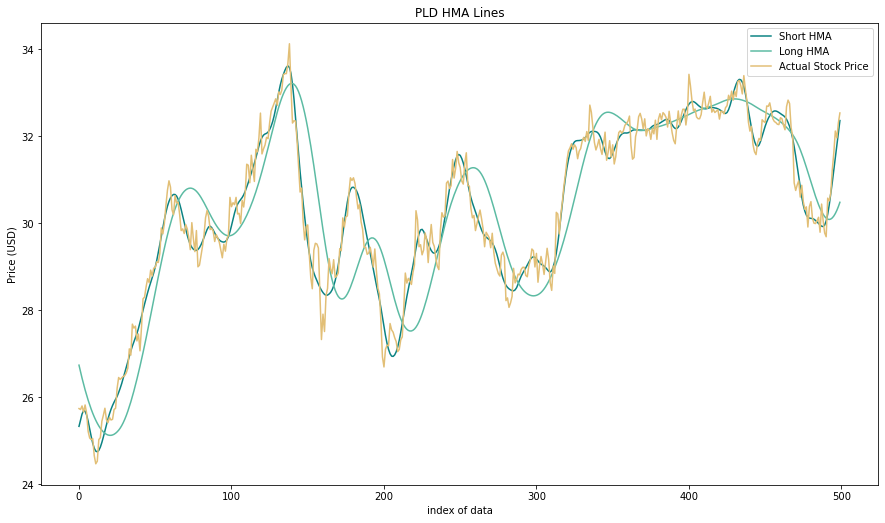

In [17]:
#both hull moving averages and underlying stock displayed
plt.plot(stock_data['PLD']['price'][0:500], color = '#0B8383', label = 'Short HMA')
plt.plot(stock_data['PLD']['support'][0:500], color = '#5CBBA3', label = 'Long HMA')
plt.plot(stock_data['PLD']['underlying_stock'][0:500], color = '#E2BF76', label = 'Actual Stock Price')
plt.title('PLD HMA Lines')
plt.xlabel('index of data')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

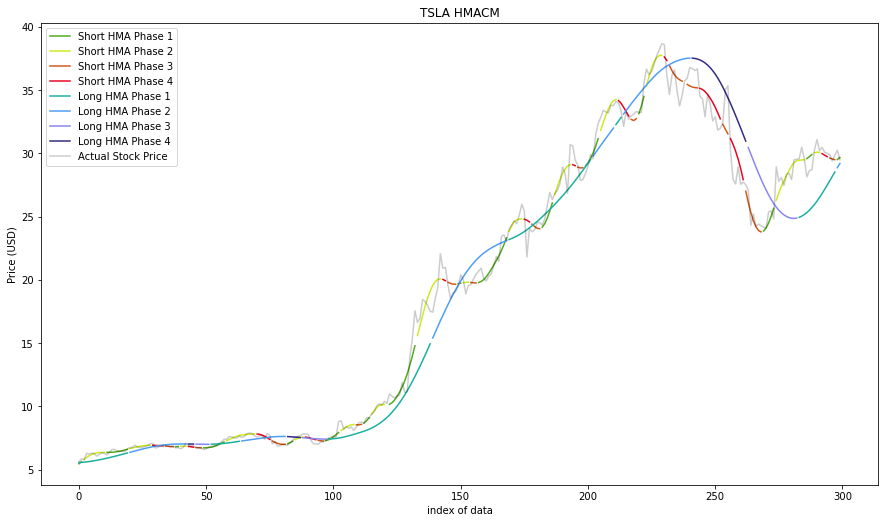

In [18]:
plt.plot(np.where(stock_data['TSLA']['phase']== 1,stock_data['TSLA']['price'], None)[:300], color="#51AC1C", label = 'Short HMA Phase 1')
plt.plot(np.where(stock_data['TSLA']['phase']== 2,stock_data['TSLA']['price'], None)[:300], color="#CDEA24", label = 'Short HMA Phase 2')
plt.plot(np.where(stock_data['TSLA']['phase']== 3,stock_data['TSLA']['price'], None)[:300], color="#D2591A", label = 'Short HMA Phase 3')
plt.plot(np.where(stock_data['TSLA']['phase']== 4,stock_data['TSLA']['price'], None)[:300], color="#E80420", label = 'Short HMA Phase 4')


plt.plot(np.where(stock_data['TSLA']['phase support']== 1,stock_data['TSLA']['support'], None)[:300], color="#19B09F", label = 'Long HMA Phase 1')
plt.plot(np.where(stock_data['TSLA']['phase support']== 2,stock_data['TSLA']['support'], None)[:300], color="#4E9DF8", label = 'Long HMA Phase 2')
plt.plot(np.where(stock_data['TSLA']['phase support']== 3,stock_data['TSLA']['support'], None)[:300], color="#8985F2", label = 'Long HMA Phase 3')
plt.plot(np.where(stock_data['TSLA']['phase support']== 4,stock_data['TSLA']['support'], None)[:300], color="#302B81", label = 'Long HMA Phase 4')

plt.plot(np.where(stock_data['TSLA']['phase']!= 6,stock_data['TSLA']['underlying_stock'], None)[:300], color="black", label = 'Actual Stock Price', alpha = .2)

plt.title('TSLA HMACM')
plt.legend()
plt.xlabel('index of data')
plt.ylabel('Price (USD)')
plt.show()

#date time index made HMACM indicators choppy, so I opted in to just use index data to represent time progression

##### Correlation Heatmap

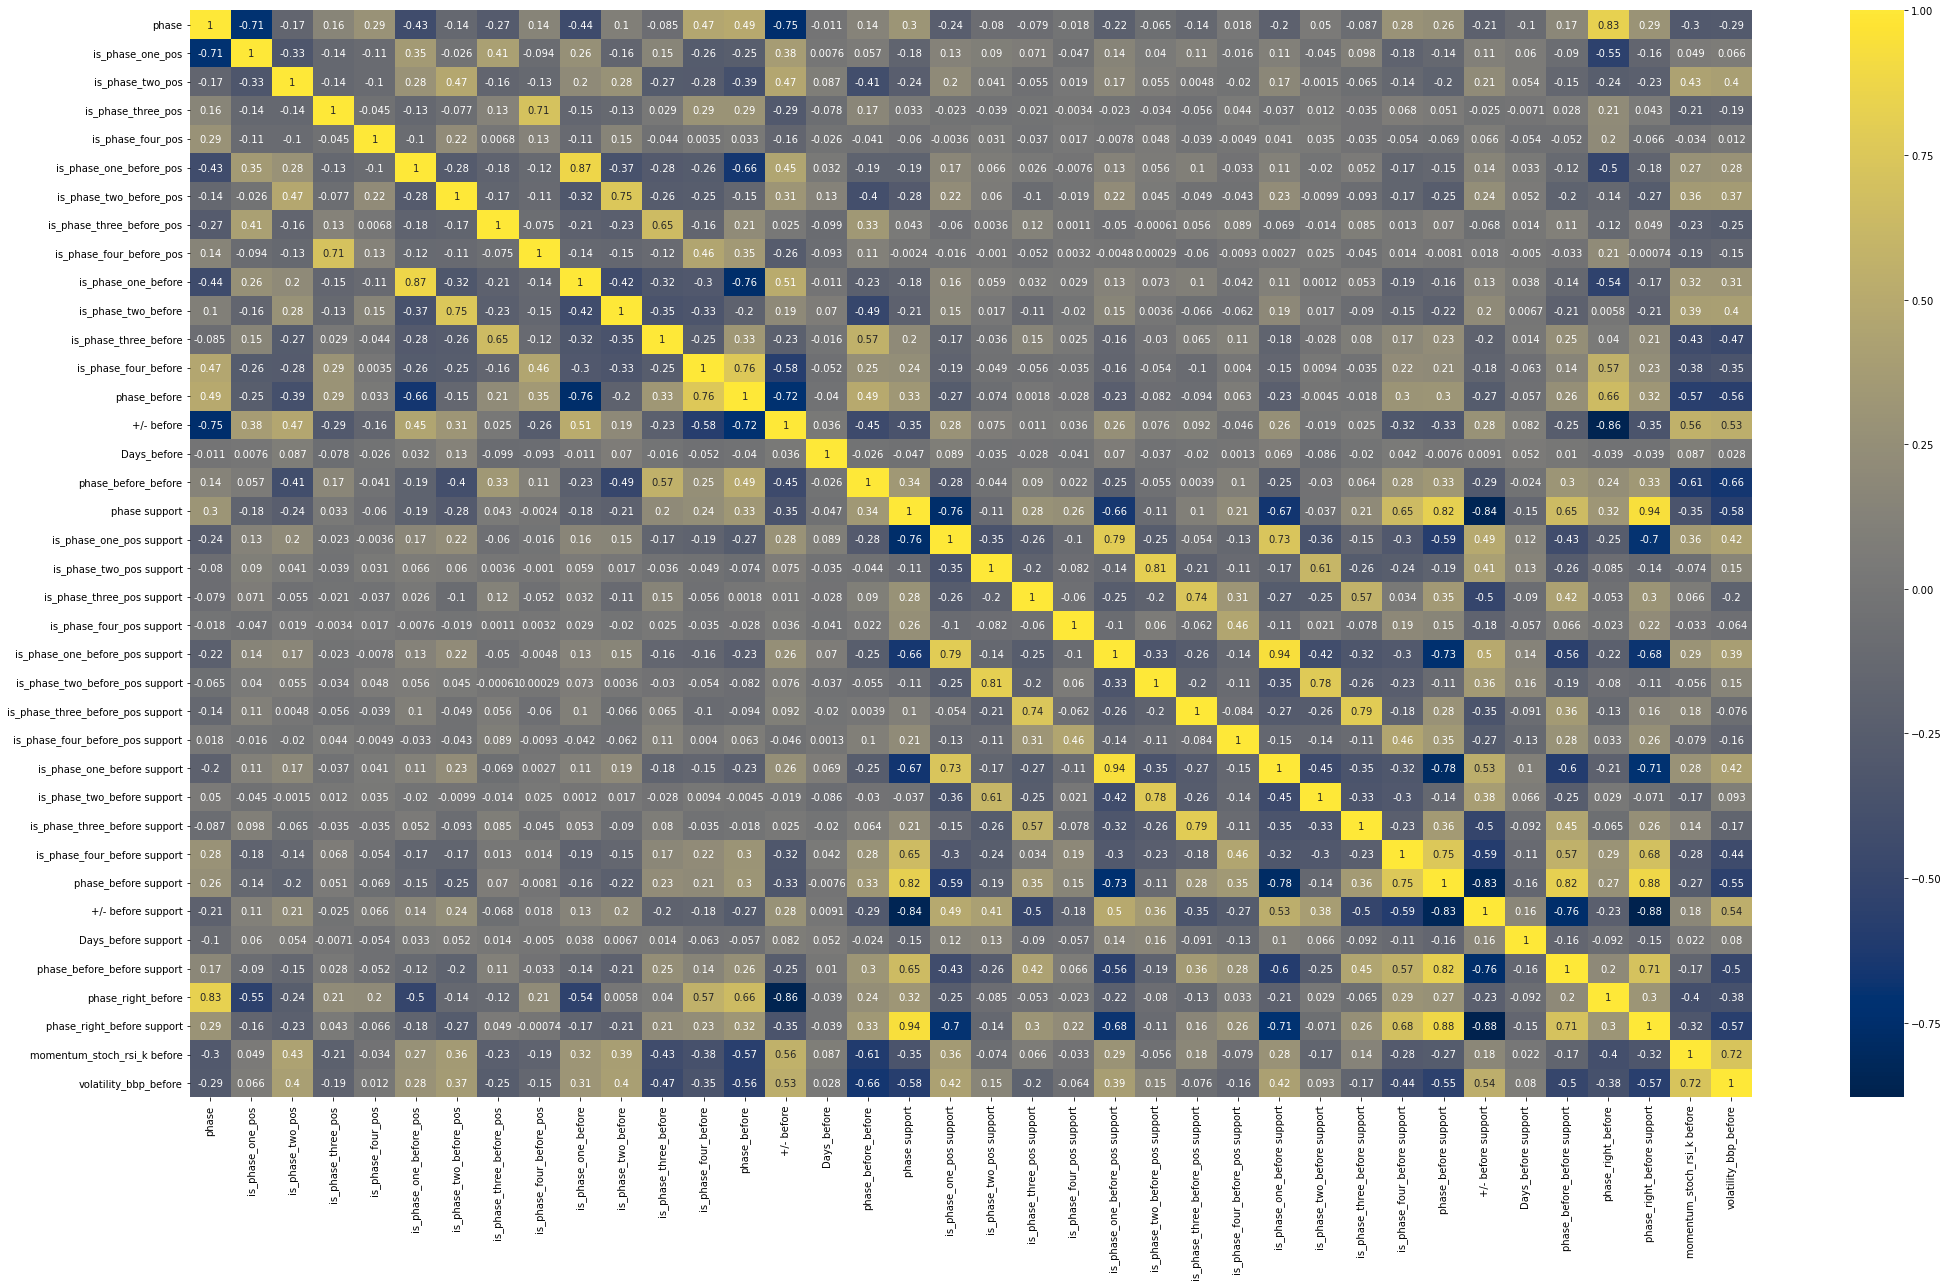

In [19]:
# A really dense correlation heat map, if zoomed in it can be read
cor = stock_data['PLD'][['phase', 'is_phase_one_pos',
       'is_phase_two_pos', 'is_phase_three_pos', 'is_phase_four_pos',
       'is_phase_one_before_pos', 'is_phase_two_before_pos',
       'is_phase_three_before_pos', 'is_phase_four_before_pos',
       'is_phase_one_before', 'is_phase_two_before', 'is_phase_three_before',
       'is_phase_four_before','phase_before','+/- before','Days_before','phase_before_before',
       'phase support', 'is_phase_one_pos support','is_phase_two_pos support', 'is_phase_three_pos support', 
       'is_phase_four_pos support','is_phase_one_before_pos support', 'is_phase_two_before_pos support',
       'is_phase_three_before_pos support', 'is_phase_four_before_pos support','is_phase_one_before support', 
       'is_phase_two_before support', 'is_phase_three_before support', 'is_phase_four_before support',
       'phase_before support','+/- before support','Days_before support','phase_before_before support',
       'phase_right_before','phase_right_before support','momentum_stoch_rsi_k before', 'volatility_bbp_before']].corr()
plt.rcParams["figure.figsize"] = (35,20)
sns.heatmap(cor,annot=True, cmap=plt.cm.cividis)
plt.show()

##### Groupby Data

###### Numeric Table data

In [20]:
#Phase support and phase yields per stock
for s in stocks:
    print(s)
    display(stock_data[s][['phase','phase support','overall_underlying_pct_change_in_phase']].groupby(['phase support','phase']).describe())

PLD


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      275.0  1.037188   
              2                                      352.0  1.024702   
              3                                       82.0  0.997103   
              4                                       82.0  0.996456   
2             1                                      206.0  1.020903   
              2                                      243.0  1.009943   
              3                                      142.0  0.993564   
              4                                      146.0  0.983236   
3             1                                      160.0  1.042379   
              2                                      115.0  1.013226   
              3                                      135.0  0.982259   
              4                                       81.0  0.971873   
4             1                                       41.0  1.011745   
              2                                       70.0  1.002706   
              3                                      155.0  0.965432   
              4                                      162.0  0.941898   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.030538  0.966335  1.011910  1.034904  1.054892   
              2      0.031923  0.968162  1.005131  1.022588  1.034514   
              3      0.015936  0.970276  0.987686  0.996581  1.004457   
              4      0.025105  0.951607  0.978295  0.996843  1.005974   
2             1      0.015629  0.963984  1.011986  1.020765  1.031870   
              2      0.018627  0.964181  1.002216  1.009529  1.020597   
              3      0.018330  0.964286  0.978919  0.994303  1.004928   
              4      0.030617  0.744719  0.975527  0.988726  0.997688   
3             1      0.059910  0.966602  1.013581  1.032248  1.053497   
              2      0.022557  0.968139  0.997525  1.011815  1.022893   
              3      0.027961  0.902586  0.975585  0.988683  0.995270   
              4      0.033583  0.898686  0.957595  0.979332  0.996028   
4             1      0.023310  0.984300  0.993516  1.011723  1.022051   
              2      0.016292  0.964181  0.992581  1.001267  1.012901   
              3      0.041593  0.849801  0.947301  0.979622  0.996071   
              4      0.067094  0.744719  0.936482  0.961733  0.981969   

                               
                          max  
phase support phase            
1             1      1.133169  
              2      1.124072  
              3      1.045183  
              4      1.052442  
2             1      1.052319  
              2      1.050676  
              3      1.045183  
              4      1.020840  
3             1      1.307875  
              2      1.052232  
              3      1.044359  
              4      1.028447  
4             1      1.076142  
              2      1.033040  
              3      1.025302  
              4      1.016639

EQIX


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      269.0  1.037064   
              2                                      286.0  1.028813   
              3                                       79.0  1.003592   
              4                                       55.0  0.988525   
2             1                                      176.0  1.021735   
              2                                      249.0  1.014989   
              3                                      158.0  0.992138   
              4                                      147.0  0.969049   
3             1                                      162.0  1.032013   
              2                                      134.0  1.015566   
              3                                      140.0  0.991125   
              4                                      104.0  0.979060   
4             1                                       46.0  1.016101   
              2                                       60.0  1.013977   
              3                                      188.0  0.977460   
              4                                      194.0  0.942143   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.030864  0.985716  1.013767  1.035839  1.056450   
              2      0.024875  0.984860  1.012774  1.022650  1.047434   
              3      0.022660  0.946385  0.989118  1.009622  1.020076   
              4      0.028902  0.920233  0.974165  0.990911  1.000000   
2             1      0.019775  0.985716  1.005080  1.024983  1.038521   
              2      0.018181  0.981709  1.001114  1.012221  1.029058   
              3      0.019904  0.948295  0.977457  0.991138  1.003024   
              4      0.035852  0.877203  0.955732  0.982288  0.992021   
3             1      0.033617  0.979116  1.006769  1.020828  1.052634   
              2      0.022768  0.968361  0.998882  1.011925  1.032169   
              3      0.029897  0.946385  0.968779  0.995964  1.007377   
              4      0.025926  0.892166  0.968331  0.979267  0.995552   
4             1      0.027126  0.979622  0.996724  1.009879  1.022137   
              2      0.022268  0.953995  0.998447  1.019244  1.030347   
              3      0.039981  0.897779  0.951286  0.988642  1.006423   
              4      0.042717  0.840338  0.917326  0.955280  0.975117   

                               
                          max  
phase support phase            
1             1      1.128280  
              2      1.090378  
              3      1.036723  
              4      1.036776  
2             1      1.062426  
              2      1.064670  
              3      1.073952  
              4      1.008563  
3             1      1.128280  
              2      1.061098  
              3      1.096586  
              4      1.029940  
4             1      1.099532  
              2      1.053465  
              3      1.096586  
              4      1.041468

O


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      264.0  1.035335   
              2                                      317.0  1.018346   
              3                                       66.0  0.995503   
              4                                       68.0  0.994990   
2             1                                      207.0  1.022460   
              2                                      234.0  1.009400   
              3                                      154.0  0.986312   
              4                                      183.0  0.969534   
3             1                                      165.0  1.020475   
              2                                      142.0  1.017358   
              3                                      138.0  0.991127   
              4                                       68.0  0.979995   
4             1                                       65.0  1.012225   
              2                                       55.0  1.004487   
              3                                      188.0  0.970626   
              4                                      133.0  0.958325   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.024354  0.973980  1.017418  1.030679  1.058093   
              2      0.017204  0.975966  1.004882  1.017904  1.030117   
              3      0.020415  0.941003  0.986648  0.994890  1.003275   
              4      0.022971  0.941939  0.985677  0.999125  1.006445   
2             1      0.020835  0.982603  1.006562  1.019929  1.033356   
              2      0.021114  0.901979  1.000238  1.008912  1.020340   
              3      0.019688  0.900766  0.978173  0.990822  0.999368   
              4      0.031865  0.885642  0.941928  0.976862  0.995463   
3             1      0.026589  0.878500  1.011987  1.023398  1.032473   
              2      0.019675  0.989779  1.005519  1.013706  1.032133   
              3      0.022896  0.930332  0.976504  0.992414  1.006934   
              4      0.031959  0.911095  0.968870  0.980086  0.993166   
4             1      0.018450  0.983417  0.997772  1.015403  1.029563   
              2      0.015207  0.974819  0.994255  1.003703  1.008325   
              3      0.040076  0.839976  0.959804  0.974334  0.991702   
              4      0.025431  0.885642  0.941267  0.957685  0.970119   

                               
                          max  
phase support phase            
1             1      1.082815  
              2      1.063441  
              3      1.052010  
              4      1.036640  
2             1      1.066714  
              2      1.044122  
              3      1.012119  
              4      1.021116  
3             1      1.068658  
              2      1.081324  
              3      1.031183  
              4      1.066817  
4             1      1.042970  
              2      1.032762  
              3      1.025551  
              4      1.016864

NKE


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      272.0  1.040560   
              2                                      283.0  1.022670   
              3                                      101.0  0.993667   
              4                                       58.0  0.997370   
2             1                                      205.0  1.031160   
              2                                      277.0  1.010801   
              3                                      118.0  0.991422   
              4                                      138.0  0.986027   
3             1                                      115.0  1.040662   
              2                                      120.0  1.018220   
              3                                      133.0  0.982404   
              4                                      115.0  0.971154   
4             1                                       67.0  1.018054   
              2                                       64.0  1.003662   
              3                                      204.0  0.985703   
              4                                      177.0  0.958117   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.039905  0.990057  1.013693  1.028411  1.055268   
              2      0.020971  0.979011  1.008372  1.024636  1.036207   
              3      0.023211  0.906030  0.987220  0.993755  1.005868   
              4      0.016567  0.945771  0.992180  0.995873  1.006571   
2             1      0.040395  0.935951  1.007396  1.017583  1.042980   
              2      0.022664  0.918882  0.996573  1.010157  1.023071   
              3      0.037205  0.906030  0.975592  0.991920  1.006299   
              4      0.025002  0.894992  0.971901  0.986572  1.002452   
3             1      0.067872  0.984363  1.004854  1.016330  1.062385   
              2      0.021271  0.976569  1.000910  1.017636  1.031992   
              3      0.037949  0.884177  0.959320  0.991765  1.011073   
              4      0.037810  0.871438  0.951364  0.985400  0.998698   
4             1      0.033911  0.968597  0.996005  1.010489  1.043896   
              2      0.017883  0.974143  0.991603  1.004764  1.010995   
              3      0.028165  0.884177  0.979457  0.989134  1.002993   
              4      0.035901  0.894992  0.930083  0.961062  0.986200   

                               
                          max  
phase support phase            
1             1      1.181818  
              2      1.074862  
              3      1.037736  
              4      1.023959  
2             1      1.129128  
              2      1.057057  
              3      1.070926  
              4      1.035712  
3             1      1.325319  
              2      1.057581  
              3      1.032642  
              4      1.007566  
4             1      1.080600  
              2      1.036522  
              3      1.030239  
              4      1.014652

LULU


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      277.0  1.078926   
              2                                      306.0  1.035786   
              3                                      100.0  0.985720   
              4                                       82.0  0.998986   
2             1                                      138.0  1.024111   
              2                                      194.0  1.028208   
              3                                      145.0  0.988493   
              4                                      146.0  0.967079   
3             1                                      165.0  1.056071   
              2                                      141.0  1.009721   
              3                                      162.0  0.976903   
              4                                      118.0  0.952178   
4             1                                       57.0  1.029032   
              2                                       67.0  1.014667   
              3                                      184.0  0.955743   
              4                                      165.0  0.928019   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.074996  0.949550  1.026156  1.058711  1.098435   
              2      0.042993  0.961701  1.006967  1.034284  1.056506   
              3      0.039454  0.880060  0.956949  0.988902  1.002421   
              4      0.032520  0.899670  0.983916  0.997471  1.023791   
2             1      0.030390  0.960183  0.999858  1.021082  1.046204   
              2      0.039709  0.948194  1.000569  1.024740  1.038839   
              3      0.034845  0.880060  0.969576  0.994513  1.005714   
              4      0.051013  0.828127  0.931626  0.972889  0.998102   
3             1      0.049066  0.981336  1.017207  1.046548  1.102212   
              2      0.032154  0.925401  0.994861  1.007243  1.028373   
              3      0.038606  0.885075  0.953359  0.980823  1.002135   
              4      0.045610  0.856519  0.915213  0.956536  0.984698   
4             1      0.040662  0.981333  1.000000  1.019742  1.038052   
              2      0.023905  0.973677  0.996789  1.009686  1.022443   
              3      0.056187  0.775191  0.924166  0.961057  0.995209   
              4      0.065243  0.806610  0.884714  0.937722  0.975481   

                               
                          max  
phase support phase            
1             1      1.265399  
              2      1.148680  
              3      1.095734  
              4      1.066471  
2             1      1.112705  
              2      1.148680  
              3      1.063819  
              4      1.075766  
3             1      1.144416  
              2      1.091345  
              3      1.069662  
              4      1.054357  
4             1      1.114393  
              2      1.080565  
              3      1.069662  
              4      1.061758

TJX


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      275.0  1.040621   
              2                                      273.0  1.019444   
              3                                      110.0  0.997109   
              4                                       85.0  0.984480   
2             1                                      173.0  1.023116   
              2                                      249.0  1.010693   
              3                                      136.0  0.993550   
              4                                      150.0  0.985712   
3             1                                      135.0  1.030723   
              2                                      123.0  1.013195   
              3                                      168.0  0.982608   
              4                                       85.0  0.986768   
4             1                                       76.0  1.027952   
              2                                       77.0  1.005172   
              3                                      173.0  0.970856   
              4                                      159.0  0.965134   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.034667  0.964788  1.012455  1.042070  1.057087   
              2      0.023393  0.966127  0.999426  1.019406  1.034152   
              3      0.017496  0.943770  0.988403  0.996727  1.005105   
              4      0.024729  0.893036  0.975959  0.988943  0.996907   
2             1      0.027575  0.986153  1.004324  1.015235  1.032152   
              2      0.019000  0.969711  1.000486  1.007334  1.018998   
              3      0.017077  0.955313  0.979017  0.996449  1.004150   
              4      0.021331  0.893036  0.976585  0.987672  0.997197   
3             1      0.032023  0.975242  1.008203  1.023468  1.036124   
              2      0.028617  0.967642  0.998696  1.008647  1.013830   
              3      0.030031  0.906819  0.968051  0.988030  1.004819   
              4      0.023906  0.942000  0.969604  0.987230  1.002920   
4             1      0.041808  0.954183  0.999932  1.017689  1.052810   
              2      0.021268  0.950275  0.997766  1.002380  1.020034   
              3      0.040848  0.831442  0.951660  0.982185  0.993300   
              4      0.038083  0.884736  0.956819  0.975219  0.986055   

                               
                          max  
phase support phase            
1             1      1.132288  
              2      1.066744  
              3      1.053045  
              4      1.022522  
2             1      1.132288  
              2      1.062312  
              3      1.025838  
              4      1.024150  
3             1      1.140950  
              2      1.114638  
              3      1.053045  
              4      1.037524  
4             1      1.140950  
              2      1.042039  
              3      1.021999  
              4      1.068480

TSM


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      295.0  1.062841   
              2                                      319.0  1.019621   
              3                                       98.0  0.996426   
              4                                       77.0  0.994649   
2             1                                      167.0  1.025481   
              2                                      243.0  1.013446   
              3                                      160.0  0.997314   
              4                                      180.0  0.972828   
3             1                                      170.0  1.045341   
              2                                      104.0  1.011629   
              3                                      129.0  0.976998   
              4                                       46.0  0.983477   
4             1                                       49.0  1.011954   
              2                                       55.0  1.003366   
              3                                      193.0  0.966077   
              4                                      162.0  0.940925   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.052829  0.947051  1.021585  1.057723  1.097611   
              2      0.026908  0.968044  1.003117  1.018432  1.035403   
              3      0.016628  0.950799  0.986470  0.997640  1.009769   
              4      0.019376  0.932731  0.984868  0.999560  1.009477   
2             1      0.029410  0.975277  1.000000  1.026584  1.045195   
              2      0.025224  0.967447  0.993286  1.011811  1.025469   
              3      0.020254  0.940816  0.990221  0.998121  1.007220   
              4      0.035826  0.875018  0.965100  0.978885  0.997840   
3             1      0.037351  0.957347  1.014452  1.039402  1.078878   
              2      0.024131  0.959032  0.994482  1.013468  1.027407   
              3      0.023291  0.933541  0.961276  0.979508  0.992991   
              4      0.014327  0.948163  0.975903  0.979141  0.994577   
4             1      0.020236  0.990069  0.997461  1.003828  1.020279   
              2      0.021104  0.954191  0.990416  1.006210  1.021417   
              3      0.033955  0.888264  0.940332  0.976563  0.985636   
              4      0.053610  0.786615  0.918253  0.941054  0.974231   

                               
                          max  
phase support phase            
1             1      1.182112  
              2      1.095467  
              3      1.021101  
              4      1.019375  
2             1      1.092634  
              2      1.095467  
              3      1.043632  
              4      1.018748  
3             1      1.169735  
              2      1.057196  
              3      1.016350  
              4      1.007671  
4             1      1.057513  
              2      1.035654  
              3      1.029197  
              4      1.036319

NVDA


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      286.0  1.083931   
              2                                      335.0  1.052786   
              3                                      101.0  1.001819   
              4                                       79.0  0.972047   
2             1                                      185.0  1.042236   
              2                                      256.0  1.036895   
              3                                      186.0  0.993217   
              4                                      162.0  0.962890   
3             1                                      112.0  1.063433   
              2                                      145.0  1.010528   
              3                                      125.0  0.971637   
              4                                       85.0  0.953771   
4             1                                       74.0  1.047239   
              2                                       52.0  1.006048   
              3                                      150.0  0.952388   
              4                                      114.0  0.937260   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.061859  0.981672  1.032242  1.081685  1.112985   
              2      0.057494  0.946079  1.022818  1.043555  1.080289   
              3      0.035197  0.947464  0.980757  0.999099  1.014698   
              4      0.049323  0.846119  0.962866  0.979869  1.005950   
2             1      0.040286  0.933201  1.014411  1.044344  1.074662   
              2      0.049684  0.934436  1.004162  1.022818  1.057845   
              3      0.046220  0.799566  0.974286  0.987720  1.017626   
              4      0.040645  0.838635  0.945999  0.968156  0.992155   
3             1      0.067175  0.971994  1.011468  1.046689  1.113341   
              2      0.028646  0.963841  0.989036  1.007545  1.029695   
              3      0.051755  0.863747  0.921392  0.978574  1.006377   
              4      0.097408  0.702461  0.931656  0.975745  0.989604   
4             1      0.046039  0.994359  1.016241  1.025322  1.068853   
              2      0.032845  0.934436  0.984392  1.001231  1.022875   
              3      0.065276  0.799566  0.911387  0.968137  0.998293   
              4      0.048308  0.838635  0.915655  0.946840  0.957715   

                               
                          max  
phase support phase            
1             1      1.235891  
              2      1.277152  
              3      1.139438  
              4      1.037100  
2             1      1.161800  
              2      1.277152  
              3      1.139438  
              4      1.025908  
3             1      1.228335  
              2      1.085977  
              3      1.073719  
              4      1.092471  
4             1      1.161800  
              2      1.084070  
              3      1.042859  
              4      1.059743

TSLA


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      270.0  1.150070   
              2                                      336.0  1.070270   
              3                                       86.0  1.001447   
              4                                       64.0  0.977219   
2             1                                      159.0  1.071720   
              2                                      215.0  1.049549   
              3                                      145.0  0.986074   
              4                                      181.0  0.945659   
3             1                                      147.0  1.071164   
              2                                      130.0  1.024989   
              3                                      155.0  0.971820   
              4                                       86.0  0.959498   
4             1                                       48.0  1.047148   
              2                                       49.0  1.007195   
              3                                      194.0  0.945762   
              4                                      182.0  0.924480   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.153314  0.941923  1.040723  1.088629  1.244538   
              2      0.066438  0.913397  1.035913  1.059015  1.107090   
              3      0.039768  0.876092  0.991049  1.007333  1.029337   
              4      0.038446  0.919400  0.957490  0.974057  0.996532   
2             1      0.081365  0.949019  1.028540  1.049495  1.114615   
              2      0.073161  0.906429  1.011837  1.035913  1.056251   
              3      0.041078  0.848846  0.967394  0.990215  1.010004   
              4      0.052504  0.820013  0.899815  0.941423  0.980998   
3             1      0.081944  0.911769  1.017756  1.057585  1.123974   
              2      0.044827  0.916222  1.004176  1.022631  1.046446   
              3      0.063840  0.843932  0.919482  0.984120  1.025324   
              4      0.062349  0.809355  0.948474  0.968874  1.001495   
4             1      0.045006  0.994566  1.018042  1.028842  1.062066   
              2      0.038048  0.922747  0.988529  1.000000  1.022336   
              3      0.067498  0.837302  0.899286  0.939134  0.993040   
              4      0.070777  0.801627  0.883389  0.924304  0.977749   

                               
                          max  
phase support phase            
1             1      1.598107  
              2      1.325444  
              3      1.069917  
              4      1.082120  
2             1      1.376214  
              2      1.325444  
              3      1.070140  
              4      1.053129  
3             1      1.338033  
              2      1.135917  
              3      1.103741  
              4      1.044037  
4             1      1.169997  
              2      1.069598  
              3      1.123206  
              4      1.057436

MGM


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      223.0  1.071900   
              2                                      256.0  1.050396   
              3                                       67.0  1.011499   
              4                                       53.0  0.985553   
2             1                                      160.0  1.037846   
              2                                      196.0  1.025240   
              3                                      169.0  0.988298   
              4                                      149.0  0.970987   
3             1                                      158.0  1.048053   
              2                                      155.0  1.021168   
              3                                      169.0  0.971883   
              4                                      111.0  0.966505   
4             1                                       86.0  1.019404   
              2                                       88.0  1.001128   
              3                                      196.0  0.954209   
              4                                      211.0  0.950502   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.069994  0.964967  1.021075  1.063169  1.094339   
              2      0.051796  0.972710  1.012833  1.038663  1.080512   
              3      0.036452  0.945614  0.983670  1.011012  1.037573   
              4      0.027660  0.940103  0.964229  0.988342  1.001203   
2             1      0.038938  0.982097  1.016105  1.031026  1.051667   
              2      0.041152  0.932166  0.995367  1.020656  1.040715   
              3      0.036994  0.887228  0.970769  0.994987  1.012142   
              4      0.034685  0.894979  0.940373  0.977509  0.990474   
3             1      0.064651  0.908880  1.005992  1.048951  1.089290   
              2      0.064533  0.906638  0.991923  1.014182  1.048439   
              3      0.067964  0.585859  0.953717  0.979709  1.004559   
              4      0.044889  0.828473  0.961036  0.972554  0.989237   
4             1      0.031100  0.936483  1.000376  1.014687  1.028233   
              2      0.029177  0.932166  0.988450  1.000691  1.026041   
              3      0.083268  0.585859  0.944403  0.972195  0.987973   
              4      0.053535  0.733409  0.928791  0.960034  0.985261   

                               
                          max  
phase support phase            
1             1      1.301082  
              2      1.200929  
              3      1.071057  
              4      1.034619  
2             1      1.152841  
              2      1.132667  
              3      1.069453  
              4      1.041480  
3             1      1.301082  
              2      1.264118  
              3      1.093599  
              4      1.042282  
4             1      1.111111  
              2      1.047167  
              3      1.055892  
              4      1.042282

MAR


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      264.0  1.049641   
              2                                      276.0  1.040739   
              3                                       85.0  0.986300   
              4                                       45.0  0.982378   
2             1                                      157.0  1.032616   
              2                                      244.0  1.025527   
              3                                      121.0  0.982168   
              4                                      174.0  0.974293   
3             1                                      151.0  1.036781   
              2                                      174.0  1.018141   
              3                                      131.0  0.962528   
              4                                       91.0  0.983020   
4             1                                       84.0  1.027154   
              2                                       79.0  1.003817   
              3                                      212.0  0.959927   
              4                                      159.0  0.958934   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.039740  0.964190  1.016501  1.043738  1.067330   
              2      0.036235  0.973508  1.010411  1.040745  1.064477   
              3      0.025502  0.903469  0.968419  0.989717  1.005381   
              4      0.033215  0.882905  0.968465  0.992097  1.001310   
2             1      0.035646  0.975377  1.008067  1.023348  1.056194   
              2      0.044877  0.946926  0.996886  1.018992  1.040734   
              3      0.029374  0.898025  0.968419  0.988846  1.000000   
              4      0.036248  0.864238  0.952629  0.976527  0.997913   
3             1      0.040541  0.907957  1.006250  1.030764  1.072103   
              2      0.057615  0.950274  0.997979  1.008264  1.016133   
              3      0.060581  0.716948  0.957219  0.969679  0.997178   
              4      0.034679  0.908850  0.965913  0.974664  0.999255   
4             1      0.039615  0.955807  0.999424  1.018198  1.063169   
              2      0.018702  0.964498  0.993800  1.000000  1.018394   
              3      0.055756  0.716948  0.950480  0.973521  0.987064   
              4      0.039252  0.847349  0.940220  0.967139  0.981244   

                               
                          max  
phase support phase            
1             1      1.162955  
              2      1.106593  
              3      1.019634  
              4      1.020818  
2             1      1.146484  
              2      1.191951  
              3      1.020244  
              4      1.038102  
3             1      1.104853  
              2      1.290635  
              3      1.019184  
              4      1.073238  
4             1      1.114845  
              2      1.043767  
              3      1.019440  
              4      1.020095

SBUX


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      306.0  1.033234   
              2                                      254.0  1.020504   
              3                                      121.0  0.995084   
              4                                       72.0  0.986617   
2             1                                      199.0  1.023997   
              2                                      282.0  1.018535   
              3                                      113.0  0.993743   
              4                                      149.0  0.982365   
3             1                                      118.0  1.021738   
              2                                      117.0  1.004690   
              3                                      127.0  0.986553   
              4                                      128.0  0.981293   
4             1                                       59.0  1.014510   
              2                                       82.0  1.000857   
              3                                      191.0  0.976390   
              4                                      129.0  0.962960   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.031795  0.980462  1.009803  1.025443  1.049736   
              2      0.018465  0.960855  1.009316  1.017555  1.030356   
              3      0.021761  0.934455  0.983965  0.999807  1.005317   
              4      0.026552  0.909903  0.979153  0.989977  1.001943   
2             1      0.021929  0.950615  1.009270  1.027884  1.044750   
              2      0.021482  0.969327  1.004669  1.015324  1.028574   
              3      0.020990  0.953836  0.979324  0.994399  1.011630   
              4      0.022991  0.926430  0.969838  0.984425  0.997329   
3             1      0.025779  0.980462  1.003777  1.014988  1.044007   
              2      0.013549  0.982182  0.990633  1.002679  1.017588   
              3      0.033469  0.866568  0.980477  0.988677  1.002435   
              4      0.030060  0.930209  0.962221  0.978281  0.999898   
4             1      0.019865  0.975644  1.002990  1.015933  1.029699   
              2      0.017680  0.958451  0.988057  1.004654  1.009848   
              3      0.026758  0.866568  0.963310  0.977927  0.995323   
              4      0.038933  0.903098  0.927055  0.962077  0.989696   

                               
                          max  
phase support phase            
1             1      1.119572  
              2      1.056453  
              3      1.034968  
              4      1.025592  
2             1      1.052804  
              2      1.074588  
              3      1.029066  
              4      1.033341  
3             1      1.070551  
              2      1.029592  
              3      1.040595  
              4      1.086675  
4             1      1.056635  
              2      1.047176  
              3      1.014392  
              4      1.038959

EBAY


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      222.0  1.050461   
              2                                      290.0  1.031402   
              3                                       66.0  0.997675   
              4                                       81.0  0.972944   
2             1                                      120.0  1.024570   
              2                                      183.0  1.014505   
              3                                      169.0  0.988231   
              4                                      148.0  0.976566   
3             1                                      176.0  1.027137   
              2                                      119.0  1.009391   
              3                                      214.0  0.992810   
              4                                      116.0  0.966663   
4             1                                       86.0  1.005615   
              2                                       71.0  1.005322   
              3                                      189.0  0.980187   
              4                                      197.0  0.949578   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.038947  0.983514  1.020619  1.049141  1.067404   
              2      0.041732  0.968553  1.007495  1.024890  1.048447   
              3      0.015450  0.957216  0.989440  0.997988  1.006170   
              4      0.035623  0.893562  0.960085  0.978811  1.002918   
2             1      0.024778  0.969194  1.005812  1.016729  1.038678   
              2      0.024272  0.946520  0.998774  1.012611  1.024897   
              3      0.021769  0.945503  0.977636  0.993092  1.007339   
              4      0.026558  0.897681  0.970035  0.982747  0.992084   
3             1      0.032252  0.933874  1.008055  1.021799  1.045805   
              2      0.019116  0.971473  0.997462  1.008075  1.022886   
              3      0.024110  0.939974  0.976171  0.992529  1.007927   
              4      0.043231  0.877213  0.943393  0.977006  0.995817   
4             1      0.023296  0.945602  0.990102  1.011076  1.019562   
              2      0.023015  0.943510  1.000000  1.009096  1.017035   
              3      0.030175  0.914672  0.963649  0.972818  0.994419   
              4      0.045118  0.833333  0.924099  0.956327  0.986952   

                               
                          max  
phase support phase            
1             1      1.177083  
              2      1.167925  
              3      1.031269  
              4      1.019633  
2             1      1.080472  
              2      1.074135  
              3      1.019658  
              4      1.013967  
3             1      1.177083  
              2      1.049873  
              3      1.094271  
              4      1.050737  
4             1      1.059647  
              2      1.036463  
              3      1.094271  
              4      1.038251

AMZN


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      285.0  1.063075   
              2                                      284.0  1.025889   
              3                                      112.0  1.000481   
              4                                      103.0  0.983821   
2             1                                      171.0  1.033819   
              2                                      208.0  1.016357   
              3                                      181.0  0.989140   
              4                                      168.0  0.980785   
3             1                                      139.0  1.038347   
              2                                      165.0  1.015378   
              3                                       89.0  0.981668   
              4                                       96.0  0.965722   
4             1                                       68.0  1.017413   
              2                                       51.0  1.002846   
              3                                      200.0  0.957353   
              4                                      127.0  0.937037   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.045048  0.922205  1.034318  1.052401  1.095738   
              2      0.024887  0.974875  1.012394  1.026108  1.038196   
              3      0.022447  0.953762  0.991448  1.000912  1.011406   
              4      0.029116  0.831789  0.969634  0.987532  0.999538   
2             1      0.031159  0.922205  1.014521  1.033389  1.054240   
              2      0.024902  0.946339  1.000325  1.016583  1.033171   
              3      0.028352  0.900444  0.975691  0.990966  1.009608   
              4      0.035015  0.900514  0.956135  0.984658  1.005232   
3             1      0.045341  0.918330  1.010992  1.033717  1.073690   
              2      0.025453  0.972431  0.998522  1.012896  1.023722   
              3      0.047766  0.862048  0.952233  0.995228  1.009310   
              4      0.048361  0.831789  0.939123  0.979928  0.994668   
4             1      0.025941  0.966355  1.002176  1.012507  1.036286   
              2      0.024981  0.946339  0.979827  1.001616  1.024596   
              3      0.042187  0.862048  0.933522  0.964832  0.991755   
              4      0.050556  0.808452  0.918144  0.949721  0.967780   

                               
                          max  
phase support phase            
1             1      1.183596  
              2      1.083869  
              3      1.044302  
              4      1.078331  
2             1      1.093338  
              2      1.083869  
              3      1.034270  
              4      1.078331  
3             1      1.183596  
              2      1.083750  
              3      1.064098  
              4      1.055240  
4             1      1.079202  
              2      1.044334  
              3      1.028533  
              4      1.033730

AAPL


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      299.0  1.047872   
              2                                      310.0  1.026091   
              3                                       74.0  1.002642   
              4                                       71.0  0.985883   
2             1                                      187.0  1.025733   
              2                                      238.0  1.012421   
              3                                      137.0  0.986825   
              4                                      165.0  0.979071   
3             1                                      130.0  1.040464   
              2                                      126.0  1.021394   
              3                                      148.0  0.981362   
              4                                       98.0  0.968761   
4             1                                       73.0  1.029363   
              2                                       45.0  1.012755   
              3                                      166.0  0.971725   
              4                                      180.0  0.926971   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.035781  0.991143  1.020822  1.038722  1.068644   
              2      0.027012  0.978272  1.007465  1.021891  1.042757   
              3      0.020857  0.947170  0.998944  1.010152  1.015618   
              4      0.020853  0.950746  0.972020  0.986921  1.002060   
2             1      0.026146  0.979272  1.003332  1.024818  1.041437   
              2      0.022013  0.938567  1.000298  1.011871  1.027159   
              3      0.027143  0.933086  0.969741  0.988891  1.010163   
              4      0.035123  0.867981  0.971030  0.984425  1.003623   
3             1      0.036440  0.932170  1.024366  1.033292  1.063840   
              2      0.018753  0.985900  1.009315  1.022770  1.034226   
              3      0.038117  0.892756  0.961579  0.986165  0.997680   
              4      0.036953  0.903836  0.953111  0.976103  0.996349   
4             1      0.030464  0.974802  1.009687  1.026146  1.052053   
              2      0.023619  0.973795  0.990654  1.005978  1.027521   
              3      0.025066  0.926656  0.952171  0.971324  0.989926   
              4      0.054215  0.800059  0.867981  0.940946  0.974385   

                               
                          max  
phase support phase            
1             1      1.160874  
              2      1.104925  
              3      1.025207  
              4      1.019011  
2             1      1.095294  
              2      1.081848  
              3      1.033886  
              4      1.028289  
3             1      1.108872  
              2      1.071612  
              3      1.066188  
              4      1.041961  
4             1      1.091352  
              2      1.052854  
              3      1.031236  
              4      1.019397

JPM


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      249.0  1.038064   
              2                                      274.0  1.030190   
              3                                       67.0  0.997611   
              4                                       60.0  0.981412   
2             1                                      193.0  1.026155   
              2                                      256.0  1.012104   
              3                                      162.0  0.991485   
              4                                      187.0  0.980531   
3             1                                      163.0  1.037146   
              2                                      108.0  1.017860   
              3                                      120.0  0.985923   
              4                                       78.0  0.970752   
4             1                                       64.0  1.013261   
              2                                       78.0  1.002193   
              3                                      207.0  0.978298   
              4                                      181.0  0.947764   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.030186  0.976396  1.014393  1.040553  1.056050   
              2      0.023737  0.986419  1.011345  1.027797  1.050491   
              3      0.027739  0.944499  0.981078  0.997525  1.014015   
              4      0.016139  0.960380  0.965017  0.984272  0.995691   
2             1      0.031165  0.965992  1.004262  1.017571  1.044682   
              2      0.027210  0.974401  0.998560  1.007625  1.019388   
              3      0.021579  0.952907  0.975491  0.996032  1.006134   
              4      0.025368  0.895061  0.970419  0.984434  0.997951   
3             1      0.034637  0.919656  1.024327  1.040553  1.056990   
              2      0.034071  0.967378  1.001520  1.006487  1.025202   
              3      0.022438  0.946125  0.969403  0.985729  1.005173   
              4      0.027541  0.908733  0.950681  0.974491  0.992929   
4             1      0.025347  0.953650  0.990106  1.014255  1.029062   
              2      0.017993  0.967378  0.987107  1.006594  1.021083   
              3      0.025768  0.942791  0.952907  0.975921  0.994396   
              4      0.056643  0.786265  0.941525  0.964041  0.977808   

                               
                          max  
phase support phase            
1             1      1.107190  
              2      1.165862  
              3      1.055218  
              4      1.005548  
2             1      1.107190  
              2      1.165862  
              3      1.055218  
              4      1.017359  
3             1      1.089088  
              2      1.133703  
              3      1.032804  
              4      1.007234  
4             1      1.068917  
              2      1.023344  
              3      1.038506  
              4      1.010758

BAC


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      229.0  1.056621   
              2                                      330.0  1.033554   
              3                                       52.0  0.987484   
              4                                       57.0  0.989599   
2             1                                      178.0  1.033768   
              2                                      203.0  1.016350   
              3                                      198.0  0.994732   
              4                                      178.0  0.981596   
3             1                                      135.0  1.032463   
              2                                      116.0  1.021714   
              3                                      151.0  0.984132   
              4                                       78.0  0.957581   
4             1                                       82.0  1.024085   
              2                                       62.0  0.998430   
              3                                      214.0  0.968029   
              4                                      184.0  0.945760   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.046380  0.970031  1.029180  1.055389  1.070907   
              2      0.029341  0.969417  1.010485  1.034869  1.052207   
              3      0.019442  0.946522  0.981437  0.993880  1.000001   
              4      0.019789  0.952420  0.983568  0.989608  1.004676   
2             1      0.036017  0.931396  1.012208  1.033658  1.049366   
              2      0.030152  0.961191  0.996039  1.010091  1.021503   
              3      0.024648  0.921188  0.981029  0.999140  1.008355   
              4      0.021601  0.920039  0.966490  0.981520  0.992236   
3             1      0.040579  0.870158  1.016927  1.032038  1.055022   
              2      0.028906  0.969225  0.997252  1.021040  1.035904   
              3      0.029471  0.906272  0.964410  0.980337  1.008386   
              4      0.051779  0.835329  0.945725  0.974983  0.994885   
4             1      0.034546  0.944226  1.012417  1.017879  1.035759   
              2      0.015168  0.969225  0.990584  0.997253  1.006922   
              3      0.033471  0.893288  0.958050  0.970518  0.988115   
              4      0.047301  0.835329  0.930660  0.951713  0.977808   

                               
                          max  
phase support phase            
1             1      1.218447  
              2      1.106968  
              3      1.019448  
              4      1.017273  
2             1      1.115158  
              2      1.110510  
              3      1.064207  
              4      1.046385  
3             1      1.101339  
              2      1.078756  
              3      1.035163  
              4      1.008372  
4             1      1.107202  
              2      1.024874  
              3      1.041243  
              4      1.019846

SCHW


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      252.0  1.051155   
              2                                      334.0  1.032762   
              3                                       63.0  0.997348   
              4                                       56.0  0.997941   
2             1                                      188.0  1.025131   
              2                                      262.0  1.017008   
              3                                      165.0  0.991194   
              4                                      175.0  0.974637   
3             1                                      142.0  1.058173   
              2                                      108.0  1.019853   
              3                                      140.0  0.988826   
              4                                       81.0  0.976113   
4             1                                       50.0  1.025847   
              2                                       72.0  1.004835   
              3                                      183.0  0.971451   
              4                                      176.0  0.931755   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.043336  0.979062  1.024919  1.052251  1.067192   
              2      0.035097  0.962431  1.010361  1.026888  1.045255   
              3      0.016408  0.940305  0.995763  0.998108  1.002572   
              4      0.032117  0.916940  0.996190  1.001561  1.008651   
2             1      0.038332  0.960575  0.997815  1.023524  1.034366   
              2      0.029253  0.955329  0.995541  1.014148  1.029661   
              3      0.026517  0.900464  0.977776  0.988485  1.007206   
              4      0.038267  0.876378  0.945494  0.986250  1.000323   
3             1      0.054019  0.976264  1.022200  1.045868  1.087547   
              2      0.025428  0.967846  1.007957  1.023070  1.034051   
              3      0.032120  0.904097  0.974232  0.989904  1.006099   
              4      0.027122  0.916940  0.959601  0.982143  0.990829   
4             1      0.035730  0.960855  1.001345  1.013622  1.055709   
              2      0.018160  0.981878  0.991189  1.002253  1.014975   
              3      0.037920  0.900464  0.950533  0.970434  1.001847   
              4      0.051303  0.819602  0.897642  0.937467  0.962990   

                               
                          max  
phase support phase            
1             1      1.186078  
              2      1.140339  
              3      1.022352  
              4      1.062518  
2             1      1.142138  
              2      1.140339  
              3      1.064212  
              4      1.030871  
3             1      1.189061  
              2      1.064265  
              3      1.051547  
              4      1.026230  
4             1      1.091588  
              2      1.041912  
              3      1.064212  
              4      1.044109

JNJ


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      265.0  1.026671   
              2                                      284.0  1.014292   
              3                                       94.0  0.999048   
              4                                       77.0  0.991309   
2             1                                      184.0  1.016499   
              2                                      229.0  1.006660   
              3                                      135.0  0.993743   
              4                                      156.0  0.986974   
3             1                                      175.0  1.026127   
              2                                      115.0  1.009166   
              3                                      132.0  0.982418   
              4                                      116.0  0.983684   
4             1                                       67.0  1.009021   
              2                                       76.0  1.002764   
              3                                      203.0  0.982432   
              4                                      139.0  0.960300   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.014397  1.000275  1.016475  1.026617  1.034461   
              2      0.017785  0.973677  1.003077  1.010902  1.020276   
              3      0.008665  0.979460  0.994423  0.999471  1.007569   
              4      0.014016  0.952873  0.983034  0.990555  1.002021   
2             1      0.014412  0.990872  1.007313  1.014999  1.028662   
              2      0.013417  0.973677  0.998553  1.007909  1.014940   
              3      0.013660  0.952947  0.988150  0.994406  1.000937   
              4      0.015497  0.956508  0.984837  0.988894  0.996727   
3             1      0.021784  0.999159  1.010022  1.019427  1.036888   
              2      0.015517  0.973030  0.999156  1.009999  1.018991   
              3      0.031191  0.874149  0.975976  0.987342  1.000763   
              4      0.015428  0.952873  0.972113  0.981174  0.994606   
4             1      0.020979  0.984911  0.998092  1.007075  1.014306   
              2      0.012347  0.973030  0.998310  0.999576  1.005098   
              3      0.019455  0.937366  0.977136  0.986312  0.990896   
              4      0.031652  0.886047  0.956508  0.964101  0.978144   

                               
                          max  
phase support phase            
1             1      1.088972  
              2      1.085140  
              3      1.011085  
              4      1.014223  
2             1      1.057188  
              2      1.033963  
              3      1.021987  
              4      1.018046  
3             1      1.088972  
              2      1.049643  
              3      1.020317  
              4      1.012587  
4             1      1.073309  
              2      1.038249  
              3      1.021987  
              4      1.011432

ABBV


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      279.0  1.053388   
              2                                      293.0  1.025797   
              3                                       73.0  0.998306   
              4                                       62.0  0.983782   
2             1                                      168.0  1.027939   
              2                                      222.0  1.015957   
              3                                      147.0  0.996996   
              4                                      163.0  0.977558   
3             1                                      132.0  1.032607   
              2                                      142.0  1.016819   
              3                                      126.0  0.989117   
              4                                      107.0  0.967957   
4             1                                       66.0  1.008491   
              2                                       85.0  0.996760   
              3                                      179.0  0.994070   
              4                                      160.0  0.947603   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.043841  0.985204  1.022674  1.046981  1.065386   
              2      0.030208  0.967189  1.005222  1.024016  1.038998   
              3      0.022395  0.935166  0.981551  1.000730  1.012192   
              4      0.032558  0.912715  0.966795  0.992331  1.002098   
2             1      0.023011  0.991046  1.006177  1.020120  1.044530   
              2      0.022594  0.967869  1.000328  1.015852  1.029627   
              3      0.019067  0.960196  0.981947  0.995827  1.007570   
              4      0.023921  0.933572  0.958944  0.975248  0.999240   
3             1      0.035300  0.975186  1.013023  1.025335  1.047630   
              2      0.035728  0.964063  1.000786  1.006441  1.032297   
              3      0.029916  0.901317  0.978735  0.991137  1.007838   
              4      0.040023  0.848678  0.959365  0.975019  0.995143   
4             1      0.021753  0.975186  1.000000  1.010094  1.021690   
              2      0.015896  0.968065  0.982437  0.997383  1.005410   
              3      0.039850  0.919310  0.979514  0.993042  1.009066   
              4      0.052410  0.848678  0.933434  0.962973  0.988288   

                               
                          max  
phase support phase            
1             1      1.221901  
              2      1.129198  
              3      1.032142  
              4      1.050084  
2             1      1.073784  
              2      1.070203  
              3      1.043374  
              4      1.024416  
3             1      1.129661  
              2      1.129198  
              3      1.044358  
              4      1.018180  
4             1      1.069648  
              2      1.041020  
              3      1.140944  
              4      1.017726

NVS


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      244.0  1.024733   
              2                                      307.0  1.017853   
              3                                       84.0  0.995956   
              4                                       56.0  0.994355   
2             1                                      166.0  1.018858   
              2                                      238.0  1.009624   
              3                                      164.0  0.999124   
              4                                      147.0  0.978892   
3             1                                      163.0  1.021494   
              2                                      119.0  1.009104   
              3                                      150.0  0.990560   
              4                                       81.0  0.985556   
4             1                                       61.0  1.022796   
              2                                       71.0  0.997725   
              3                                      199.0  0.987024   
              4                                      197.0  0.972561   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.020111  0.989202  1.010742  1.021188  1.034166   
              2      0.019342  0.974753  1.004836  1.014841  1.029880   
              3      0.010662  0.978267  0.986239  0.998486  1.000907   
              4      0.018658  0.951052  0.988233  0.996421  1.003923   
2             1      0.020764  0.986847  1.004023  1.016270  1.033614   
              2      0.015066  0.975098  1.000215  1.009808  1.019993   
              3      0.015478  0.954675  0.989843  0.998640  1.005219   
              4      0.020419  0.925448  0.964929  0.985650  0.992969   
3             1      0.020208  0.972399  1.011164  1.017818  1.032940   
              2      0.019804  0.970703  0.995691  1.013498  1.021514   
              3      0.021967  0.925009  0.983626  0.990699  1.001487   
              4      0.018560  0.943205  0.973434  0.990206  0.997462   
4             1      0.027258  0.976757  1.009889  1.017962  1.034376   
              2      0.011997  0.977403  0.991771  0.997677  1.006629   
              3      0.021009  0.925009  0.978353  0.987091  0.998688   
              4      0.036442  0.852348  0.958150  0.985361  0.998562   

                               
                          max  
phase support phase            
1             1      1.069990  
              2      1.060380  
              3      1.024096  
              4      1.019637  
2             1      1.068627  
              2      1.051256  
              3      1.036254  
              4      1.008652  
3             1      1.069990  
              2      1.052067  
              3      1.033470  
              4      1.013407  
4             1      1.068906  
              2      1.027983  
              3      1.032754  
              4      1.012180

AMGN


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      257.0  1.046058   
              2                                      285.0  1.029034   
              3                                       66.0  0.985680   
              4                                       53.0  0.995572   
2             1                                      136.0  1.024482   
              2                                      221.0  1.019903   
              3                                      147.0  0.990671   
              4                                      186.0  0.972156   
3             1                                      146.0  1.034764   
              2                                      146.0  1.008769   
              3                                      171.0  0.988586   
              4                                      102.0  0.981969   
4             1                                       91.0  1.010084   
              2                                       77.0  1.007275   
              3                                      202.0  0.981467   
              4                                      161.0  0.975592   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.031092  0.985185  1.024135  1.043142  1.064424   
              2      0.034547  0.975328  1.004671  1.021308  1.044088   
              3      0.013915  0.938252  0.974806  0.988999  0.997222   
              4      0.012916  0.965911  0.992397  0.999035  1.003551   
2             1      0.027046  0.972620  1.003761  1.016427  1.040742   
              2      0.038163  0.960000  0.997506  1.012503  1.026600   
              3      0.025455  0.908002  0.973643  0.991420  1.004802   
              4      0.029814  0.914715  0.947112  0.975663  0.999291   
3             1      0.028224  0.979118  1.019727  1.036049  1.053317   
              2      0.021873  0.971768  0.989492  1.007628  1.019139   
              3      0.034478  0.947852  0.967875  0.984761  0.998782   
              4      0.024129  0.933440  0.965725  0.982767  1.002041   
4             1      0.018952  0.979710  0.996888  1.005571  1.022284   
              2      0.024681  0.964057  0.995033  1.008108  1.026808   
              3      0.029869  0.908002  0.961390  0.988826  0.999024   
              4      0.025794  0.922895  0.959072  0.977297  0.994241   

                               
                          max  
phase support phase            
1             1      1.128861  
              2      1.132501  
              3      1.009036  
              4      1.021611  
2             1      1.090635  
              2      1.132501  
              3      1.070683  
              4      1.040232  
3             1      1.127161  
              2      1.052383  
              3      1.110294  
              4      1.026005  
4             1      1.046411  
              2      1.067894  
              3      1.070683  
              4      1.022341

XOM


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      239.0  1.044781   
              2                                      241.0  1.027509   
              3                                       83.0  1.004389   
              4                                       57.0  0.993503   
2             1                                      138.0  1.018157   
              2                                      262.0  1.016175   
              3                                      128.0  0.993029   
              4                                      158.0  0.964975   
3             1                                      135.0  1.021513   
              2                                      148.0  1.010866   
              3                                      178.0  0.983953   
              4                                      106.0  0.995663   
4             1                                       75.0  1.012473   
              2                                       58.0  0.994695   
              3                                      229.0  0.980797   
              4                                      212.0  0.940726   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.037245  0.988125  1.011129  1.043292  1.060347   
              2      0.042451  0.960550  1.004686  1.021655  1.030614   
              3      0.028280  0.957782  0.988897  0.998799  1.014897   
              4      0.017266  0.954042  0.982199  0.997803  1.004276   
2             1      0.030126  0.976596  0.997465  1.009192  1.034743   
              2      0.026321  0.942278  1.003335  1.012833  1.023658   
              3      0.025747  0.943481  0.978317  0.990251  1.003518   
              4      0.043564  0.833124  0.950583  0.975308  0.992211   
3             1      0.024875  0.974801  1.005343  1.023925  1.037343   
              2      0.035231  0.973927  0.994077  1.000953  1.014084   
              3      0.022130  0.940052  0.972883  0.985086  0.993118   
              4      0.021788  0.955418  0.981287  0.995872  1.008338   
4             1      0.024003  0.977091  0.999751  1.010440  1.019093   
              2      0.011792  0.973927  0.984224  0.991599  1.003486   
              3      0.023418  0.935621  0.963271  0.978388  0.998373   
              4      0.089184  0.685164  0.932328  0.968672  0.985728   

                               
                          max  
phase support phase            
1             1      1.145314  
              2      1.191598  
              3      1.080593  
              4      1.032036  
2             1      1.102863  
              2      1.113921  
              3      1.060053  
              4      1.036227  
3             1      1.094665  
              2      1.140267  
              3      1.080593  
              4      1.043088  
4             1      1.094665  
              2      1.021023  
              3      1.064317  
              4      1.036227

SU


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      217.0  1.048197   
              2                                      297.0  1.043451   
              3                                       58.0  1.005440   
              4                                       39.0  0.986458   
2             1                                      130.0  1.041131   
              2                                      194.0  1.019445   
              3                                      139.0  0.994218   
              4                                      169.0  0.963086   
3             1                                      174.0  1.042411   
              2                                      121.0  1.013953   
              3                                      197.0  0.972874   
              4                                      129.0  0.971437   
4             1                                       60.0  1.020571   
              2                                       81.0  1.000966   
              3                                      219.0  0.962361   
              4                                      223.0  0.924993   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.052033  0.955030  1.010697  1.044268  1.068083   
              2      0.047787  0.884858  1.017835  1.033941  1.062563   
              3      0.025079  0.903432  0.991756  1.014208  1.019187   
              4      0.018444  0.948920  0.971133  0.985234  0.996342   
2             1      0.040924  0.949864  1.020379  1.038504  1.066622   
              2      0.043395  0.884858  0.990577  1.014009  1.033927   
              3      0.031374  0.903052  0.980500  0.991616  1.011887   
              4      0.032108  0.859447  0.942004  0.961538  0.988794   
3             1      0.042046  0.970848  1.017044  1.037443  1.058514   
              2      0.021712  0.960388  1.000608  1.013447  1.026871   
              3      0.037274  0.808496  0.952990  0.975586  1.000284   
              4      0.037720  0.882330  0.936243  0.972138  0.999669   
4             1      0.029836  0.973386  1.000628  1.014267  1.044627   
              2      0.022197  0.962641  0.990984  1.000000  1.014257   
              3      0.045060  0.808496  0.941005  0.967630  0.988118   
              4      0.084182  0.629184  0.911536  0.950175  0.968057   

                               
                          max  
phase support phase            
1             1      1.212577  
              2      1.270309  
              3      1.040107  
              4      1.025421  
2             1      1.135579  
              2      1.164665  
              3      1.065016  
              4      1.025421  
3             1      1.144920  
              2      1.064403  
              3      1.034687  
              4      1.042735  
4             1      1.098413  
              2      1.045871  
              3      1.054306  
              4      1.023775

D


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      274.0  1.028575   
              2                                      267.0  1.017242   
              3                                      110.0  1.000888   
              4                                       77.0  0.996619   
2             1                                      130.0  1.018250   
              2                                      243.0  1.010639   
              3                                      140.0  0.993256   
              4                                      170.0  0.981260   
3             1                                      150.0  1.017837   
              2                                      167.0  1.010029   
              3                                      140.0  0.991439   
              4                                      103.0  0.978985   
4             1                                       70.0  1.008054   
              2                                       58.0  1.007325   
              3                                      185.0  0.982813   
              4                                      163.0  0.967835   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.024718  0.986898  1.013915  1.023891  1.039554   
              2      0.021068  0.964196  1.001318  1.016411  1.029835   
              3      0.012145  0.961103  0.991939  1.002703  1.009719   
              4      0.016887  0.942596  0.991227  0.995820  1.005196   
2             1      0.020367  0.979485  1.001171  1.017804  1.034700   
              2      0.013585  0.979829  1.001389  1.008063  1.017795   
              3      0.013002  0.964214  0.987101  0.994157  1.003281   
              4      0.021953  0.935986  0.963024  0.989044  0.998630   
3             1      0.024755  0.910428  1.005412  1.017547  1.029989   
              2      0.027568  0.961702  0.995664  1.008230  1.021177   
              3      0.023054  0.910416  0.978979  0.993948  1.006503   
              4      0.018367  0.942596  0.965767  0.983369  0.992582   
4             1      0.014900  0.975482  0.997894  1.004582  1.024973   
              2      0.011970  0.982973  0.998188  1.007590  1.015921   
              3      0.022898  0.910416  0.974750  0.983517  0.989410   
              4      0.026186  0.903965  0.950496  0.968829  0.985634   

                               
                          max  
phase support phase            
1             1      1.092993  
              2      1.098649  
              3      1.019933  
              4      1.032754  
2             1      1.079900  
              2      1.046918  
              3      1.018038  
              4      1.025597  
3             1      1.092993  
              2      1.098649  
              3      1.025275  
              4      1.015634  
4             1      1.028829  
              2      1.029194  
              3      1.066513  
              4      1.021148

NEE


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      314.0  1.035918   
              2                                      327.0  1.019813   
              3                                       98.0  0.994788   
              4                                       80.0  0.998930   
2             1                                      205.0  1.018733   
              2                                      247.0  1.014369   
              3                                      141.0  0.986483   
              4                                      173.0  0.976848   
3             1                                      156.0  1.032117   
              2                                      160.0  1.005436   
              3                                       92.0  0.984960   
              4                                       63.0  0.998659   
4             1                                       50.0  1.003810   
              2                                       32.0  0.995929   
              3                                      181.0  0.974088   
              4                                      128.0  0.954144   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.024317  0.986905  1.017787  1.031416  1.056823   
              2      0.018106  0.969778  1.007794  1.019776  1.030228   
              3      0.016184  0.958108  0.989846  0.997629  1.002979   
              4      0.012926  0.969416  0.990820  0.999278  1.010349   
2             1      0.022545  0.985614  1.000000  1.021801  1.033502   
              2      0.014910  0.988263  1.002787  1.013031  1.022647   
              3      0.025947  0.923403  0.966086  0.997932  1.004435   
              4      0.026544  0.883248  0.964834  0.984958  0.995999   
3             1      0.027996  0.978711  1.011585  1.025719  1.053914   
              2      0.018544  0.953254  0.994793  1.007089  1.019352   
              3      0.031626  0.858668  0.979130  0.989024  0.999666   
              4      0.023258  0.963944  0.985783  0.996557  1.001883   
4             1      0.011021  0.989775  0.993968  0.999698  1.015743   
              2      0.010519  0.979567  0.987633  0.996268  1.001716   
              3      0.036286  0.858668  0.969857  0.983510  0.995989   
              4      0.041930  0.854865  0.934463  0.966250  0.985915   

                               
                          max  
phase support phase            
1             1      1.103182  
              2      1.062881  
              3      1.031147  
              4      1.015972  
2             1      1.103182  
              2      1.057632  
              3      1.023826  
              4      1.022299  
3             1      1.103105  
              2      1.035645  
              3      1.031137  
              4      1.073482  
4             1      1.032074  
              2      1.014939  
              3      1.010378  
              4      1.015260

XEL


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      261.0  1.029166   
              2                                      313.0  1.024173   
              3                                       82.0  0.995712   
              4                                       85.0  0.992325   
2             1                                      197.0  1.014468   
              2                                      250.0  1.010207   
              3                                      132.0  0.993855   
              4                                      153.0  0.983730   
3             1                                      172.0  1.020253   
              2                                      155.0  1.015046   
              3                                      108.0  1.002075   
              4                                       81.0  0.985858   
4             1                                       49.0  1.008686   
              2                                       53.0  1.000222   
              3                                      179.0  0.982008   
              4                                      177.0  0.966066   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.017566  0.989677  1.019992  1.027261  1.037386   
              2      0.022401  0.987811  1.009548  1.019663  1.037102   
              3      0.011205  0.956365  0.989760  0.997840  1.004913   
              4      0.017565  0.949748  0.981243  0.995696  1.005156   
2             1      0.016281  0.976395  1.000751  1.011733  1.025269   
              2      0.014410  0.969761  0.999507  1.010101  1.019951   
              3      0.018292  0.905288  0.986749  0.996642  1.004793   
              4      0.020187  0.945419  0.964071  0.984165  1.001349   
3             1      0.021410  0.928389  1.011859  1.020222  1.033557   
              2      0.022286  0.975202  1.003293  1.011501  1.024124   
              3      0.042134  0.918539  0.984396  0.993072  1.005943   
              4      0.022721  0.928524  0.975251  0.987872  1.000458   
4             1      0.014327  0.982953  0.999504  1.008234  1.013444   
              2      0.012204  0.979109  0.992144  1.000535  1.011636   
              3      0.019151  0.905288  0.970051  0.985888  0.993166   
              4      0.035946  0.858444  0.949042  0.970849  0.989278   

                               
                          max  
phase support phase            
1             1      1.072115  
              2      1.084562  
              3      1.011739  
              4      1.025241  
2             1      1.049420  
              2      1.038334  
              3      1.016041  
              4      1.027040  
3             1      1.064001  
              2      1.084562  
              3      1.160774  
              4      1.023919  
4             1      1.034554  
              2      1.020063  
              3      1.015479  
              4      1.023467

SPWR


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      275.0  1.143422   
              2                                      250.0  1.045695   
              3                                       75.0  0.995784   
              4                                       82.0  0.990731   
2             1                                      112.0  1.120987   
              2                                      181.0  1.028641   
              3                                      148.0  0.974485   
              4                                      157.0  0.946341   
3             1                                      156.0  1.057114   
              2                                      135.0  0.999474   
              3                                      211.0  0.956752   
              4                                      133.0  0.952475   
4             1                                       81.0  1.027824   
              2                                       80.0  1.014602   
              3                                      207.0  0.912781   
              4                                      164.0  0.884879   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.116654  0.965174  1.051800  1.131296  1.198701   
              2      0.081408  0.856670  0.993708  1.030066  1.079189   
              3      0.041109  0.934462  0.955791  0.989234  1.035242   
              4      0.030455  0.949352  0.970149  0.986807  0.993902   
2             1      0.135392  0.989239  1.024403  1.058276  1.188000   
              2      0.081941  0.856670  0.977286  1.018182  1.070790   
              3      0.057725  0.846702  0.929841  0.963922  1.013635   
              4      0.085155  0.747099  0.893784  0.956989  0.981413   
3             1      0.089262  0.820090  1.000000  1.037402  1.101818   
              2      0.049598  0.879406  0.961988  1.006503  1.022746   
              3      0.064592  0.811834  0.894244  0.958589  1.004229   
              4      0.071331  0.794542  0.904715  0.968187  0.997033   
4             1      0.041265  0.948175  1.009281  1.020319  1.053254   
              2      0.062540  0.941860  0.966748  1.009038  1.033670   
              3      0.066299  0.808139  0.868852  0.908231  0.965939   
              4      0.073070  0.732094  0.846859  0.888049  0.951145   

                               
                          max  
phase support phase            
1             1      1.523996  
              2      1.314070  
              3      1.072848  
              4      1.072639  
2             1      1.523996  
              2      1.235457  
              3      1.126183  
              4      1.249401  
3             1      1.292169  
              2      1.132304  
              3      1.111307  
              4      1.132653  
4             1      1.106437  
              2      1.166954  
              3      1.046732  
              4      1.022046

LMT


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      303.0  1.031450   
              2                                      338.0  1.026709   
              3                                       80.0  0.997753   
              4                                       59.0  0.997444   
2             1                                      197.0  1.022384   
              2                                      251.0  1.010656   
              3                                      148.0  0.998254   
              4                                      168.0  0.980002   
3             1                                      125.0  1.020244   
              2                                      122.0  1.010051   
              3                                      129.0  0.989194   
              4                                       75.0  0.974686   
4             1                                       60.0  1.008761   
              2                                       63.0  1.008020   
              3                                      175.0  0.973179   
              4                                      154.0  0.959678   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.023364  0.989774  1.016775  1.025915  1.047613   
              2      0.023097  0.972638  1.013424  1.024330  1.038855   
              3      0.013000  0.966956  0.993218  0.999819  1.006440   
              4      0.012677  0.980879  0.989077  0.993983  1.004182   
2             1      0.023923  0.984745  1.003528  1.018205  1.033401   
              2      0.018245  0.972638  1.000028  1.010641  1.018063   
              3      0.021176  0.939391  0.988903  0.993048  1.001915   
              4      0.030513  0.894323  0.969647  0.992331  1.000571   
3             1      0.027956  0.970738  1.003072  1.012931  1.032462   
              2      0.021726  0.977082  0.997814  1.004684  1.014099   
              3      0.021484  0.927837  0.980619  0.986806  1.002787   
              4      0.024661  0.912054  0.968556  0.978241  0.986195   
4             1      0.019517  0.984238  0.996269  1.003985  1.018210   
              2      0.009007  0.982993  1.003216  1.007878  1.015186   
              3      0.027700  0.916274  0.955760  0.973787  0.991596   
              4      0.029189  0.887819  0.941714  0.953196  0.982791   

                               
                          max  
phase support phase            
1             1      1.110506  
              2      1.082636  
              3      1.020757  
              4      1.033123  
2             1      1.099115  
              2      1.071988  
              3      1.056748  
              4      1.021934  
3             1      1.110506  
              2      1.082636  
              3      1.035673  
              4      1.028422  
4             1      1.047515  
              2      1.018993  
              3      1.032755  
              4      1.017935

TDG


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      305.0  1.050627   
              2                                      281.0  1.027195   
              3                                       92.0  0.999463   
              4                                       93.0  0.994681   
2             1                                      183.0  1.019632   
              2                                      259.0  1.015338   
              3                                      189.0  0.993878   
              4                                      195.0  0.982609   
3             1                                      101.0  1.037639   
              2                                      138.0  1.006529   
              3                                      110.0  0.991217   
              4                                       68.0  1.001208   
4             1                                       93.0  1.018196   
              2                                       66.0  0.999600   
              3                                      163.0  0.967666   
              4                                      111.0  0.946061   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.046897  0.962460  1.022746  1.032188  1.080948   
              2      0.030106  0.947785  1.006180  1.020378  1.041186   
              3      0.014218  0.972423  0.990942  0.999715  1.004452   
              4      0.017601  0.925943  0.986311  0.992689  1.008180   
2             1      0.025280  0.979122  0.999538  1.013065  1.033901   
              2      0.035157  0.934698  0.996457  1.008366  1.024414   
              3      0.020319  0.930926  0.984974  0.997212  1.008273   
              4      0.025875  0.929957  0.962323  0.983338  0.998761   
3             1      0.045294  0.952636  1.007664  1.026654  1.053982   
              2      0.039126  0.829964  0.997007  1.007786  1.028978   
              3      0.054210  0.800177  0.969665  1.006439  1.016387   
              4      0.087085  0.833689  0.982657  0.996567  1.002775   
4             1      0.029306  0.968280  1.000000  1.010353  1.028835   
              2      0.023388  0.944657  0.994258  1.002759  1.015198   
              3      0.050409  0.800177  0.930926  0.985223  1.000816   
              4      0.052079  0.828544  0.928964  0.955781  0.966790   

                               
                          max  
phase support phase            
1             1      1.198733  
              2      1.143949  
              3      1.035361  
              4      1.025221  
2             1      1.076352  
              2      1.143949  
              3      1.037358  
              4      1.093161  
3             1      1.136229  
              2      1.093907  
              3      1.107534  
              4      1.274611  
4             1      1.094443  
              2      1.045097  
              3      1.040183  
              4      1.065896

MRCY


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      268.0  1.082886   
              2                                      305.0  1.039202   
              3                                       87.0  0.990116   
              4                                       68.0  0.986247   
2             1                                      121.0  1.019906   
              2                                      207.0  1.019039   
              3                                      137.0  0.987053   
              4                                      206.0  0.965132   
3             1                                      176.0  1.031970   
              2                                      139.0  1.015402   
              3                                      166.0  0.983627   
              4                                       99.0  0.973702   
4             1                                       69.0  1.031914   
              2                                       54.0  1.010243   
              3                                      185.0  0.972235   
              4                                      160.0  0.935237   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.064037  0.979366  1.033571  1.070423  1.112356   
              2      0.052628  0.937725  1.002187  1.025630  1.062786   
              3      0.022504  0.946530  0.973391  0.995313  1.000391   
              4      0.026196  0.935572  0.970516  0.990611  1.004538   
2             1      0.030890  0.975661  0.995240  1.015211  1.047943   
              2      0.032259  0.971980  0.994275  1.010235  1.042247   
              3      0.028788  0.916911  0.974295  0.990015  1.000000   
              4      0.046332  0.817538  0.933614  0.978366  0.998792   
3             1      0.043213  0.939418  1.003260  1.025046  1.058907   
              2      0.022125  0.973419  1.000907  1.012889  1.026471   
              3      0.033826  0.908977  0.963534  0.985090  1.004435   
              4      0.031306  0.910801  0.948864  0.984874  0.996839   
4             1      0.033685  0.973876  1.003131  1.020793  1.058198   
              2      0.025380  0.941455  0.999116  1.009448  1.031290   
              3      0.035038  0.895114  0.948435  0.976695  0.991464   
              4      0.064482  0.789806  0.900767  0.937683  0.987867   

                               
                          max  
phase support phase            
1             1      1.221713  
              2      1.197285  
              3      1.042102  
              4      1.022064  
2             1      1.107210  
              2      1.113578  
              3      1.042102  
              4      1.035892  
3             1      1.145474  
              2      1.074484  
              3      1.056553  
              4      1.026340  
4             1      1.084778  
              2      1.052895  
              3      1.058808  
              4      1.051977

FC


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      236.0  1.094830   
              2                                      263.0  1.020588   
              3                                       90.0  0.992676   
              4                                      113.0  0.982430   
2             1                                      135.0  1.028037   
              2                                      184.0  1.018309   
              3                                      211.0  0.982522   
              4                                      165.0  0.977306   
3             1                                      158.0  1.035856   
              2                                      111.0  1.031576   
              3                                      166.0  0.980181   
              4                                      106.0  0.987622   
4             1                                       70.0  1.018225   
              2                                       69.0  0.999578   
              3                                      208.0  0.958628   
              4                                      162.0  0.940134   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.084437  0.977273  1.033152  1.077554  1.106849   
              2      0.032193  0.944747  0.998110  1.018671  1.035692   
              3      0.024050  0.937773  0.984788  0.995498  1.003580   
              4      0.033835  0.888998  0.975425  0.991513  1.003049   
2             1      0.032468  0.967938  0.999376  1.031294  1.051942   
              2      0.026449  0.960280  1.000000  1.015486  1.042629   
              3      0.036166  0.883577  0.966905  0.984727  1.007229   
              4      0.045880  0.702421  0.959044  0.971512  1.001647   
3             1      0.058178  0.831995  1.012139  1.029083  1.076197   
              2      0.066025  0.970509  0.994059  1.020645  1.043017   
              3      0.038173  0.704618  0.965567  0.982127  1.004460   
              4      0.033499  0.909832  0.958975  0.988066  1.008055   
4             1      0.033541  0.961448  0.999349  1.012821  1.037303   
              2      0.018895  0.969762  0.979786  1.002732  1.014370   
              3      0.064767  0.704618  0.938571  0.965857  0.991590   
              4      0.082309  0.702421  0.923261  0.971997  0.986626   

                               
                          max  
phase support phase            
1             1      1.300493  
              2      1.102318  
              3      1.049881  
              4      1.026316  
2             1      1.093792  
              2      1.072875  
              3      1.056667  
              4      1.091756  
3             1      1.136588  
              2      1.283019  
              3      1.052219  
              4      1.050747  
4             1      1.125730  
              2      1.049096  
              3      1.078829  
              4      1.038997

AWK


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      326.0  1.032962   
              2                                      340.0  1.024720   
              3                                       81.0  0.994336   
              4                                       62.0  0.995849   
2             1                                      179.0  1.019560   
              2                                      242.0  1.015524   
              3                                      167.0  0.994058   
              4                                      183.0  0.978242   
3             1                                      123.0  1.020011   
              2                                      121.0  1.020673   
              3                                      115.0  1.003855   
              4                                       81.0  0.965724   
4             1                                       65.0  1.008772   
              2                                       76.0  1.006750   
              3                                      157.0  0.974701   
              4                                      129.0  0.959704   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.022769  0.985307  1.020245  1.030015  1.042065   
              2      0.021881  0.986687  1.007768  1.022799  1.036117   
              3      0.015971  0.945429  0.986284  0.994021  1.007039   
              4      0.017756  0.959775  0.989651  0.995833  1.012079   
2             1      0.021303  0.985307  1.004589  1.018477  1.031302   
              2      0.013619  0.992499  1.004526  1.015176  1.023771   
              3      0.018965  0.929146  0.989923  0.995187  1.003688   
              4      0.031307  0.883002  0.973134  0.985764  0.998755   
3             1      0.028318  0.890152  1.006856  1.023648  1.034033   
              2      0.032345  0.983237  1.001377  1.012063  1.021026   
              3      0.048306  0.960637  0.982486  0.996339  1.002408   
              4      0.039649  0.850940  0.953404  0.973451  0.988207   
4             1      0.012318  0.987821  0.998606  1.006856  1.021659   
              2      0.013110  0.983237  0.992444  1.008789  1.015176   
              3      0.027764  0.912565  0.960712  0.978933  0.996549   
              4      0.043049  0.839128  0.949724  0.968579  0.988207   

                               
                          max  
phase support phase            
1             1      1.087956  
              2      1.085473  
              3      1.017249  
              4      1.025447  
2             1      1.087956  
              2      1.050564  
              3      1.024738  
              4      1.020120  
3             1      1.069231  
              2      1.115607  
              3      1.199424  
              4      1.017244  
4             1      1.025335  
              2      1.029779  
              3      1.019522  
              4      1.021356

WTRG


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      279.0  1.031621   
              2                                      308.0  1.023194   
              3                                       83.0  0.994269   
              4                                       65.0  0.998634   
2             1                                      182.0  1.022515   
              2                                      252.0  1.013648   
              3                                      146.0  0.991875   
              4                                      182.0  0.973608   
3             1                                      138.0  1.024654   
              2                                      130.0  1.010963   
              3                                      116.0  0.982833   
              4                                       74.0  0.979897   
4             1                                       79.0  1.014210   
              2                                       95.0  1.002634   
              3                                      185.0  0.973231   
              4                                      133.0  0.963200   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.024147  0.981022  1.011792  1.028926  1.047191   
              2      0.026887  0.978589  1.004355  1.020935  1.037414   
              3      0.025182  0.921964  0.991092  1.000000  1.009522   
              4      0.018154  0.969716  0.981967  0.999788  1.010258   
2             1      0.018499  0.976152  1.010357  1.018336  1.033716   
              2      0.017452  0.978589  1.002809  1.011187  1.025569   
              3      0.016522  0.964039  0.974174  0.993761  1.003243   
              4      0.026762  0.862621  0.955824  0.974351  0.990871   
3             1      0.025959  0.978336  1.010381  1.021930  1.034589   
              2      0.012889  0.982804  1.001966  1.009885  1.020000   
              3      0.043315  0.823914  0.984715  0.993053  1.003423   
              4      0.018985  0.941026  0.970984  0.974043  0.996186   
4             1      0.016114  0.990595  0.999580  1.012116  1.026674   
              2      0.009932  0.984311  0.995854  1.001272  1.011132   
              3      0.033043  0.823914  0.964202  0.980313  0.986199   
              4      0.032158  0.862621  0.946182  0.967340  0.983051   

                               
                          max  
phase support phase            
1             1      1.091753  
              2      1.106754  
              3      1.019502  
              4      1.031333  
2             1      1.063928  
              2      1.055445  
              3      1.027237  
              4      1.027922  
3             1      1.117601  
              2      1.035303  
              3      1.034154  
              4      1.004468  
4             1      1.056017  
              2      1.020288  
              3      1.053476  
              4      1.019051

CAJ


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      176.0  1.035827   
              2                                      246.0  1.018741   
              3                                       65.0  1.001822   
              4                                      102.0  0.984491   
2             1                                      114.0  1.011572   
              2                                      177.0  1.014377   
              3                                      162.0  0.994227   
              4                                      158.0  0.980356   
3             1                                      157.0  1.018869   
              2                                      156.0  1.001766   
              3                                      190.0  0.989032   
              4                                      112.0  0.986143   
4             1                                       94.0  1.008932   
              2                                      100.0  1.005169   
              3                                      211.0  0.980661   
              4                                      227.0  0.957067   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.034866  0.977947  1.015847  1.028518  1.048957   
              2      0.023917  0.959607  1.004504  1.015288  1.032103   
              3      0.021010  0.977181  0.988543  0.999695  1.010163   
              4      0.022869  0.926660  0.965651  0.995091  1.000505   
2             1      0.019644  0.983044  0.998916  1.009549  1.025943   
              2      0.014766  0.974632  1.005961  1.012921  1.020700   
              3      0.018151  0.927429  0.987790  0.994945  1.002173   
              4      0.023085  0.926660  0.964322  0.985768  0.996638   
3             1      0.020955  0.974159  1.006960  1.015487  1.026811   
              2      0.019276  0.941876  0.993245  1.004504  1.009339   
              3      0.020715  0.939484  0.970418  0.989751  1.002539   
              4      0.020811  0.926660  0.974423  0.981085  0.996061   
4             1      0.019921  0.974163  0.995967  1.008169  1.027976   
              2      0.014509  0.978117  0.995056  1.002506  1.011811   
              3      0.028867  0.927429  0.970414  0.980583  0.992206   
              4      0.037176  0.849034  0.946036  0.959777  0.988102   

                               
                          max  
phase support phase            
1             1      1.136774  
              2      1.079060  
              3      1.064024  
              4      1.027695  
2             1      1.057459  
              2      1.054067  
              3      1.030873  
              4      1.020033  
3             1      1.077673  
              2      1.056878  
              3      1.063090  
              4      1.042385  
4             1      1.048262  
              2      1.036792  
              3      1.063090  
              4      1.021446

PWR


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      230.0  1.075717   
              2                                      320.0  1.033651   
              3                                      102.0  1.000253   
              4                                       83.0  0.978667   
2             1                                      151.0  1.026759   
              2                                      211.0  1.017575   
              3                                      158.0  1.002416   
              4                                      180.0  0.974528   
3             1                                      145.0  1.032690   
              2                                      144.0  1.024819   
              3                                      127.0  0.971832   
              4                                       81.0  0.995940   
4             1                                       55.0  1.013125   
              2                                       58.0  1.001198   
              3                                      218.0  0.956692   
              4                                      184.0  0.936964   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.054456  0.987383  1.030508  1.064912  1.105634   
              2      0.040657  0.961200  1.007731  1.026289  1.047826   
              3      0.026697  0.949392  0.981853  0.999719  1.023698   
              4      0.032270  0.885866  0.967268  0.987278  1.000798   
2             1      0.028864  0.984556  1.004021  1.018781  1.048729   
              2      0.023583  0.968928  1.004242  1.017468  1.026223   
              3      0.025244  0.949392  0.983302  1.000000  1.012133   
              4      0.038774  0.748397  0.964760  0.980139  0.998395   
3             1      0.024113  0.981256  1.014089  1.030152  1.048966   
              2      0.028026  0.950196  1.009616  1.024733  1.045582   
              3      0.054200  0.790369  0.957555  0.979942  1.000000   
              4      0.030730  0.933863  0.968421  0.990155  1.012495   
4             1      0.017578  0.990148  1.001531  1.009076  1.024125   
              2      0.020467  0.950196  0.986612  1.000515  1.016480   
              3      0.055051  0.790369  0.922901  0.970783  0.985747   
              4      0.060685  0.748397  0.922414  0.947651  0.969039   

                               
                          max  
phase support phase            
1             1      1.209846  
              2      1.172759  
              3      1.066397  
              4      1.014540  
2             1      1.107783  
              2      1.114426  
              3      1.066397  
              4      1.027756  
3             1      1.079132  
              2      1.082827  
              3      1.058153  
              4      1.075608  
4             1      1.072635  
              2      1.034366  
              3      1.038461  
              4      1.011653

STN


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      223.0  1.048226   
              2                                      296.0  1.020810   
              3                                       83.0  0.999881   
              4                                       67.0  0.993213   
2             1                                      165.0  1.022021   
              2                                      202.0  1.018785   
              3                                      135.0  0.995178   
              4                                      175.0  0.978109   
3             1                                      183.0  1.023996   
              2                                      135.0  1.017638   
              3                                      171.0  0.979688   
              4                                       84.0  0.973058   
4             1                                       64.0  1.012953   
              2                                       68.0  1.002357   
              3                                      200.0  0.984770   
              4                                      196.0  0.950784   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.050223  0.978625  1.012552  1.030167  1.060618   
              2      0.024223  0.979705  1.001767  1.017248  1.038551   
              3      0.019825  0.940742  0.993835  1.000000  1.006600   
              4      0.024987  0.915959  0.979386  0.997795  1.005653   
2             1      0.024619  0.982124  1.005227  1.016670  1.035299   
              2      0.023959  0.973954  1.000719  1.016358  1.028526   
              3      0.016373  0.960413  0.983538  0.994897  1.008410   
              4      0.027615  0.903188  0.955346  0.979111  1.003945   
3             1      0.027875  0.973816  1.002811  1.022853  1.036943   
              2      0.022413  0.976533  1.003342  1.015474  1.026066   
              3      0.035035  0.891279  0.942069  0.988050  1.001945   
              4      0.025493  0.915959  0.958582  0.972973  0.992331   
4             1      0.017173  0.989614  1.001120  1.007524  1.023857   
              2      0.017075  0.966540  0.991805  1.001947  1.012380   
              3      0.030537  0.891279  0.975424  0.990329  1.003002   
              4      0.050656  0.782304  0.910394  0.967544  0.983043   

                               
                          max  
phase support phase            
1             1      1.170640  
              2      1.075319  
              3      1.035185  
              4      1.049369  
2             1      1.092982  
              2      1.082335  
              3      1.024535  
              4      1.035538  
3             1      1.142798  
              2      1.075319  
              3      1.037516  
              4      1.017733  
4             1      1.047091  
              2      1.038140  
              3      1.048415  
              4      1.019791

LUV


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      291.0  1.077307   
              2                                      305.0  1.047276   
              3                                       56.0  0.999961   
              4                                       45.0  0.979019   
2             1                                      173.0  1.032920   
              2                                      210.0  1.020375   
              3                                      150.0  0.981968   
              4                                      163.0  0.967810   
3             1                                      168.0  1.047862   
              2                                      124.0  1.021116   
              3                                      140.0  0.967455   
              4                                       99.0  0.984160   
4             1                                       58.0  1.028704   
              2                                       78.0  1.010029   
              3                                      204.0  0.963877   
              4                                      183.0  0.953427   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.057685  0.986022  1.029951  1.061987  1.118514   
              2      0.042943  0.961897  1.021995  1.037591  1.065837   
              3      0.018677  0.952516  0.991783  0.998756  1.013422   
              4      0.026672  0.924817  0.952301  0.987390  0.996689   
2             1      0.033147  0.966756  1.008143  1.029141  1.050636   
              2      0.030271  0.946833  1.004329  1.016880  1.038067   
              3      0.027502  0.924483  0.974338  0.984512  1.001940   
              4      0.038240  0.908684  0.934091  0.976923  0.995414   
3             1      0.058482  0.912821  1.007581  1.034872  1.081187   
              2      0.017432  0.967980  1.010678  1.015032  1.031307   
              3      0.068537  0.800129  0.953211  0.974693  0.999614   
              4      0.060295  0.885534  0.960738  0.979827  0.993542   
4             1      0.041266  0.964895  1.007938  1.024254  1.031637   
              2      0.025059  0.967936  0.996926  1.006288  1.029346   
              3      0.041792  0.839552  0.937187  0.963750  0.986705   
              4      0.031977  0.877952  0.935568  0.958311  0.973264   

                               
                          max  
phase support phase            
1             1      1.209468  
              2      1.153053  
              3      1.020287  
              4      1.012855  
2             1      1.119427  
              2      1.100046  
              3      1.020287  
              4      1.106914  
3             1      1.187340  
              2      1.059607  
              3      1.139011  
              4      1.194172  
4             1      1.187340  
              2      1.052348  
              3      1.070263  
              4      1.024912

DAL


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      244.0  1.073338   
              2                                      284.0  1.044751   
              3                                       59.0  0.999600   
              4                                       78.0  0.965650   
2             1                                      144.0  1.036726   
              2                                      194.0  1.030480   
              3                                      169.0  0.984441   
              4                                      179.0  0.961233   
3             1                                      206.0  1.036659   
              2                                      130.0  1.020695   
              3                                      142.0  0.976236   
              4                                       75.0  0.997998   
4             1                                       66.0  1.031728   
              2                                       91.0  0.999606   
              3                                      217.0  0.954927   
              4                                      169.0  0.938133   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.049820  0.974812  1.034063  1.068424  1.115722   
              2      0.057317  0.932186  1.009450  1.032840  1.063875   
              3      0.036701  0.961454  0.974751  1.000000  1.011343   
              4      0.060664  0.768668  0.967533  0.983142  0.996145   
2             1      0.033073  0.967126  1.012979  1.039359  1.059463   
              2      0.024796  0.977223  1.012392  1.030244  1.046176   
              3      0.023423  0.945070  0.967213  0.981991  1.000000   
              4      0.044010  0.882705  0.931622  0.969147  0.985542   
3             1      0.058661  0.832578  1.005147  1.025803  1.061907   
              2      0.034847  0.932186  0.998887  1.014681  1.036058   
              3      0.036931  0.855719  0.962623  0.985138  0.997226   
              4      0.035285  0.896800  0.979889  0.989384  1.013447   
4             1      0.039919  0.973633  1.002174  1.033308  1.055541   
              2      0.029188  0.936301  0.976484  1.004091  1.023155   
              3      0.045329  0.843098  0.940078  0.967171  0.981706   
              4      0.050873  0.784696  0.917684  0.944531  0.971375   

                               
                          max  
phase support phase            
1             1      1.162277  
              2      1.255058  
              3      1.133924  
              4      1.018340  
2             1      1.162277  
              2      1.086826  
              3      1.039541  
              4      1.084926  
3             1      1.176423  
              2      1.095040  
              3      1.029289  
              4      1.096180  
4             1      1.174930  
              2      1.086826  
              3      1.059763  
              4      1.011697

GPK


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      256.0  1.043220   
              2                                      271.0  1.023156   
              3                                       81.0  0.987171   
              4                                       51.0  0.995487   
2             1                                      178.0  1.025012   
              2                                      243.0  1.014179   
              3                                      150.0  0.993269   
              4                                      186.0  0.978025   
3             1                                      143.0  1.033375   
              2                                      117.0  1.006957   
              3                                      153.0  0.986499   
              4                                       85.0  0.982655   
4             1                                       86.0  1.015626   
              2                                      114.0  1.001522   
              3                                      185.0  0.978720   
              4                                      148.0  0.957323   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.029903  0.983917  1.017709  1.044632  1.061641   
              2      0.029753  0.982958  1.001583  1.013110  1.043478   
              3      0.024653  0.926132  0.972456  0.988173  1.005642   
              4      0.024536  0.943171  0.983346  0.998521  1.004045   
2             1      0.022940  0.975361  1.007766  1.023005  1.043320   
              2      0.020489  0.956433  1.004619  1.013503  1.023721   
              3      0.022164  0.943911  0.970627  0.992638  1.008215   
              4      0.025581  0.911294  0.959011  0.982316  0.996109   
3             1      0.032114  0.935406  1.020746  1.029516  1.054226   
              2      0.028515  0.944083  0.992815  1.000000  1.022021   
              3      0.030014  0.913149  0.971890  0.992235  1.010101   
              4      0.032529  0.838482  0.973268  0.988107  0.998620   
4             1      0.026489  0.981413  1.000000  1.006177  1.027262   
              2      0.018266  0.944083  0.989054  1.001699  1.011136   
              3      0.028958  0.906050  0.963698  0.976942  0.996528   
              4      0.050119  0.838482  0.915589  0.970792  0.995165   

                               
                          max  
phase support phase            
1             1      1.103133  
              2      1.113314  
              3      1.036376  
              4      1.035768  
2             1      1.071983  
              2      1.062720  
              3      1.038269  
              4      1.035894  
3             1      1.103133  
              2      1.072598  
              3      1.037907  
              4      1.039011  
4             1      1.102201  
              2      1.045558  
              3      1.037907  
              4      1.034403

GLW


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      238.0  1.059336   
              2                                      323.0  1.024920   
              3                                      104.0  0.988471   
              4                                       91.0  0.991569   
2             1                                      154.0  1.028154   
              2                                      190.0  1.007122   
              3                                      154.0  0.988273   
              4                                      180.0  0.980577   
3             1                                      163.0  1.030868   
              2                                      129.0  1.019038   
              3                                      145.0  0.986110   
              4                                       97.0  0.966294   
4             1                                       50.0  1.009737   
              2                                       47.0  1.010876   
              3                                      195.0  0.978351   
              4                                      187.0  0.950262   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.076146  0.967633  1.010411  1.035285  1.089587   
              2      0.030832  0.975388  1.003156  1.015818  1.042225   
              3      0.033307  0.899044  0.983510  0.994440  1.004006   
              4      0.030561  0.920799  0.973123  0.996255  1.001765   
2             1      0.031615  0.971081  1.006687  1.021962  1.045904   
              2      0.019498  0.960147  0.996232  1.008852  1.020169   
              3      0.019987  0.899044  0.977543  0.992364  0.999395   
              4      0.027379  0.885646  0.970775  0.986612  1.000338   
3             1      0.038371  0.898026  1.009395  1.022988  1.055132   
              2      0.023438  0.957983  1.004926  1.012838  1.031268   
              3      0.023279  0.922996  0.968721  0.988662  1.002105   
              4      0.030486  0.916255  0.940339  0.968292  0.991477   
4             1      0.021556  0.977577  0.992064  1.002560  1.026389   
              2      0.016305  0.977455  1.003968  1.006732  1.026645   
              3      0.030637  0.922996  0.961614  0.981707  0.997890   
              4      0.038294  0.885646  0.914914  0.952224  0.974359   

                               
                          max  
phase support phase            
1             1      1.284405  
              2      1.113355  
              3      1.047228  
              4      1.044653  
2             1      1.108100  
              2      1.043500  
              3      1.024249  
              4      1.018523  
3             1      1.104225  
              2      1.064596  
              3      1.037094  
              4      1.021937  
4             1      1.052464  
              2      1.033366  
              3      1.047673  
              4      1.029486

INTU


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      280.0  1.042540   
              2                                      323.0  1.027799   
              3                                       91.0  0.997344   
              4                                       89.0  0.986550   
2             1                                      185.0  1.020047   
              2                                      263.0  1.018842   
              3                                      183.0  0.986605   
              4                                      165.0  0.982611   
3             1                                      142.0  1.029103   
              2                                      128.0  1.016943   
              3                                      110.0  0.982255   
              4                                       75.0  0.972935   
4             1                                       63.0  1.026457   
              2                                       56.0  1.015720   
              3                                      134.0  0.977124   
              4                                      160.0  0.932490   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.032158  0.974160  1.018477  1.037933  1.067420   
              2      0.020488  0.979243  1.012513  1.029831  1.042161   
              3      0.017072  0.955016  0.986214  1.000000  1.010314   
              4      0.017142  0.941736  0.975981  0.989226  0.998046   
2             1      0.025110  0.974160  1.001372  1.017484  1.028128   
              2      0.020262  0.948200  1.007134  1.020313  1.029144   
              3      0.027789  0.867829  0.968919  0.996960  1.005265   
              4      0.025201  0.926676  0.964056  0.985279  1.000370   
3             1      0.048293  0.878135  1.003101  1.023903  1.053739   
              2      0.020111  0.962487  1.004023  1.014942  1.028442   
              3      0.037007  0.892851  0.968370  0.982406  1.011147   
              4      0.028445  0.911546  0.957347  0.977425  0.992449   
4             1      0.031214  0.964866  1.003814  1.019361  1.054252   
              2      0.021031  0.975006  0.998353  1.018388  1.034513   
              3      0.038804  0.867829  0.941854  0.985621  1.004218   
              4      0.053560  0.782455  0.913784  0.945836  0.973348   

                               
                          max  
phase support phase            
1             1      1.119423  
              2      1.078008  
              3      1.025100  
              4      1.026781  
2             1      1.119423  
              2      1.060728  
              3      1.027212  
              4      1.042954  
3             1      1.121685  
              2      1.066158  
              3      1.031971  
              4      1.035443  
4             1      1.082936  
              2      1.050847  
              3      1.031971  
              4      1.020128

CSCO


overall_underlying_pct_change_in_phase            \
                                                     count      mean   
phase support phase                                                    
1             1                                      225.0  1.044339   
              2                                      298.0  1.027038   
              3                                       80.0  0.999023   
              4                                       66.0  0.991693   
2             1                                      201.0  1.030237   
              2                                      211.0  1.009936   
              3                                      162.0  0.987526   
              4                                      174.0  0.983579   
3             1                                      153.0  1.028843   
              2                                      154.0  1.007831   
              3                                      127.0  0.998569   
              4                                       99.0  0.976346   
4             1                                       73.0  1.008866   
              2                                       86.0  1.008002   
              3                                      204.0  0.975658   
              4                                      134.0  0.951073   

                                                                       \
                          std       min       25%       50%       75%   
phase support phase                                                     
1             1      0.040895  0.981663  1.017482  1.042126  1.075202   
              2      0.027948  0.988044  1.002891  1.025000  1.037634   
              3      0.017412  0.950016  0.989826  1.000360  1.008557   
              4      0.016886  0.950296  0.985214  0.995346  1.002385   
2             1      0.027741  0.981663  1.016569  1.030025  1.039687   
              2      0.019463  0.970127  0.996252  1.010040  1.019283   
              3      0.019339  0.950016  0.976229  0.988662  1.000850   
              4      0.021645  0.911138  0.977951  0.984690  0.997394   
3             1      0.033916  0.964391  1.003090  1.024328  1.040429   
              2      0.019221  0.957541  0.998695  1.009612  1.020531   
              3      0.033359  0.895491  0.983912  0.999764  1.017551   
              4      0.024317  0.936592  0.952363  0.983064  0.993321   
4             1      0.015537  0.975445  0.998173  1.009421  1.015444   
              2      0.023623  0.961807  0.993646  1.006973  1.029624   
              3      0.029466  0.895491  0.961109  0.974838  0.994118   
              4      0.032633  0.894285  0.922577  0.940631  0.982589   

                               
                          max  
phase support phase            
1             1      1.164825  
              2      1.101888  
              3      1.025919  
              4      1.024828  
2             1      1.115103  
              2      1.066682  
              3      1.036586  
              4      1.022770  
3             1      1.124044  
              2      1.043568  
              3      1.078380  
              4      1.026758  
4             1      1.041806  
              2      1.045124  
              3      1.036586  
              4      1.002407

###### phase yield data

In [21]:
phase_yield_data = stock_data[stocks[0]][['phase','phase support','overall_underlying_pct_change_in_phase']].dropna()
for s in stocks[1:]:
    phase_yield_data = pd.concat([phase_yield_data, stock_data[s][['phase','phase support','overall_underlying_pct_change_in_phase']].dropna()])

In [22]:
#Overall phase yield
phase_yield = phase_yield_data[['phase','phase support','overall_underlying_pct_change_in_phase']].groupby(['phase support','phase']).describe()

In [23]:
def style_negative(v, props=''):
    return props if v < 1 else None
def style_positive(v, props=''):
    return props if v > 1 else None
phase_yield = phase_yield.style.applymap(style_negative, props='color:#E49C03;',
                                         subset=pd.IndexSlice[:, pd.IndexSlice[:, ['mean']]])
phase_yield = phase_yield.applymap(style_positive, props='color:#5CBBA3;',
                                         subset=pd.IndexSlice[:, pd.IndexSlice[:, ['mean']]])
phase_yield.bar(subset=pd.IndexSlice[:, pd.IndexSlice[:, ['count']]], color= '#22434f')

###### Box and Whisker Plot

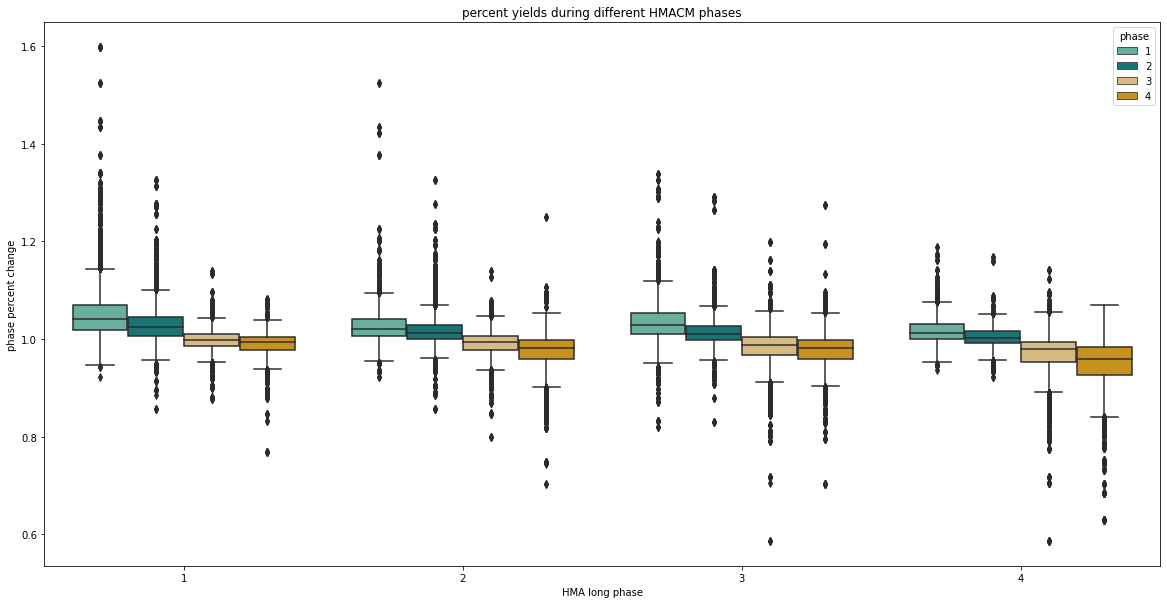

In [24]:
plt.rcParams["figure.figsize"] = (20,10)
sns.boxplot(x='phase support',y='overall_underlying_pct_change_in_phase', hue="phase",
            data=phase_yield_data, palette = ['#5CBBA3','#0B8383','#E2BF76','#E49C03'])
plt.xlabel('HMA long phase')
plt.ylabel('phase percent change')
plt.title('percent yields during different HMACM phases')
plt.show()

#### Model Creation

##### predicting short-term phase

In [25]:
#creating a test dataframe
test = stock_data[stocks[0]][['phase', 'is_phase_one_pos',
       'is_phase_two_pos', 'is_phase_three_pos', 'is_phase_four_pos',
       'is_phase_one_before_pos', 'is_phase_two_before_pos',
       'is_phase_three_before_pos', 'is_phase_four_before_pos',
       'is_phase_one_before', 'is_phase_two_before', 'is_phase_three_before',
       'is_phase_four_before','phase_before','+/- before','Days_before','phase_before_before',
       'phase support', 'is_phase_one_pos support','is_phase_two_pos support', 'is_phase_three_pos support', 
       'is_phase_four_pos support','is_phase_one_before_pos support', 'is_phase_two_before_pos support',
       'is_phase_three_before_pos support', 'is_phase_four_before_pos support','is_phase_one_before support', 
       'is_phase_two_before support', 'is_phase_three_before support', 'is_phase_four_before support',
       'phase_before support','+/- before support','Days_before support','phase_before_before support',
       'phase_right_before','phase_right_before support']].dropna()
for s in stocks[1:]:
    test = pd.concat([test, stock_data[s][['phase', 'is_phase_one_pos',
       'is_phase_two_pos', 'is_phase_three_pos', 'is_phase_four_pos',
       'is_phase_one_before_pos', 'is_phase_two_before_pos',
       'is_phase_three_before_pos', 'is_phase_four_before_pos',
       'is_phase_one_before', 'is_phase_two_before', 'is_phase_three_before',
       'is_phase_four_before','phase_before','+/- before','Days_before','phase_before_before',
       'phase support', 'is_phase_one_pos support','is_phase_two_pos support', 'is_phase_three_pos support', 
       'is_phase_four_pos support','is_phase_one_before_pos support', 'is_phase_two_before_pos support',
       'is_phase_three_before_pos support', 'is_phase_four_before_pos support','is_phase_one_before support', 
       'is_phase_two_before support', 'is_phase_three_before support', 'is_phase_four_before support',
       'phase_before support','+/- before support','Days_before support','phase_before_before support',
       'phase_right_before','phase_right_before support']]]).dropna()

In [26]:
# the target variable is the short hma phase
test = test.reset_index()
X = test[['is_phase_one_before_pos', 'is_phase_two_before_pos',
       'is_phase_three_before_pos', 'is_phase_four_before_pos',
       'is_phase_one_before', 'is_phase_two_before', 'is_phase_three_before',
       'is_phase_four_before','phase_before','+/- before','Days_before','phase_before_before',
       'is_phase_one_before_pos support', 'is_phase_two_before_pos support',
       'is_phase_three_before_pos support', 'is_phase_four_before_pos support','is_phase_one_before support', 
       'is_phase_two_before support', 'is_phase_three_before support', 'is_phase_four_before support',
       'phase_before support','+/- before support','Days_before support','phase_before_before support',
       'phase_right_before','phase_right_before support']].dropna()
y= test['phase']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=7)

In [28]:
clf =  MLPClassifier()
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 0.8474282024410641
              precision    recall  f1-score   support

           1       0.83      0.86      0.85     25149
           2       0.88      0.84      0.86     28042
           3       0.84      0.87      0.85     22040
           4       0.83      0.81      0.82     19236

    accuracy                           0.85     94467
   macro avg       0.85      0.85      0.85     94467
weighted avg       0.85      0.85      0.85     94467



In [29]:
#Testing to see if it works better than guessing the phase before
print(len(test.loc[(test.phase_before == 3) & (test.phase == 3)])/len(test.loc[test.phase_before == 3]))
print(len(test.loc[(test.phase_before == 1) & (test.phase == 1)])/len(test.loc[test.phase_before == 1]))
print(len(test.loc[(test.phase_before == 2) & (test.phase == 2)])/len(test.loc[test.phase_before == 2]))
print(len(test.loc[(test.phase_before == 4) & (test.phase == 4)])/len(test.loc[test.phase_before == 4]))

0.4401090406054195
0.4529874609276758
0.49466992036989466
0.3993834080717489


In [30]:
#Testing the most important points, transition period accuracy
tested_ind = list(y_test.index)

tested = test.loc[tested_ind]

tested['y_pred'] = y_pred

tested_transitions_ind = list(tested.loc[(tested.phase_before == tested.phase)].index)

tested_transitions = tested.loc[tested_transitions_ind]

tested_transitions[['phase','y_pred']].head(50)

count = 0
tested_transitions = pd.DataFrame(tested_transitions)
for i in tested_transitions.index:
    if tested_transitions.phase.loc[i] == tested_transitions.y_pred.loc[i]:
        count+=1
print(count/len(tested_transitions))

0.9173732296779952


##### predicting long-term phase

In [31]:
#Reseting test data
test = stock_data[stocks[0]][[
       'phase', 'is_phase_one_pos',
       'is_phase_two_pos', 'is_phase_three_pos', 'is_phase_four_pos',
       'is_phase_one_before_pos', 'is_phase_two_before_pos',
       'is_phase_three_before_pos', 'is_phase_four_before_pos',
       'is_phase_one_before', 'is_phase_two_before', 'is_phase_three_before',
       'is_phase_four_before','phase_before','+/- before','Days_before','phase_before_before',
       'phase support', 'is_phase_one_pos support','is_phase_two_pos support', 'is_phase_three_pos support', 
       'is_phase_four_pos support','is_phase_one_before_pos support', 'is_phase_two_before_pos support',
       'is_phase_three_before_pos support', 'is_phase_four_before_pos support','is_phase_one_before support', 
       'is_phase_two_before support', 'is_phase_three_before support', 'is_phase_four_before support',
       'phase_before support','+/- before support','Days_before support','phase_before_before support',
       'phase_right_before','phase_right_before support']].dropna()
for s in stocks[1:]:
    test = pd.concat([test, stock_data[s][[
       'phase', 'is_phase_one_pos',
       'is_phase_two_pos', 'is_phase_three_pos', 'is_phase_four_pos',
       'is_phase_one_before_pos', 'is_phase_two_before_pos',
       'is_phase_three_before_pos', 'is_phase_four_before_pos',
       'is_phase_one_before', 'is_phase_two_before', 'is_phase_three_before',
       'is_phase_four_before','phase_before','+/- before','Days_before','phase_before_before',
       'phase support', 'is_phase_one_pos support','is_phase_two_pos support', 'is_phase_three_pos support', 
       'is_phase_four_pos support','is_phase_one_before_pos support', 'is_phase_two_before_pos support',
       'is_phase_three_before_pos support', 'is_phase_four_before_pos support','is_phase_one_before support', 
       'is_phase_two_before support', 'is_phase_three_before support', 'is_phase_four_before support',
       'phase_before support','+/- before support','Days_before support','phase_before_before support',
       'phase_right_before','phase_right_before support']]]).dropna()

In [32]:
#The target variable is the hma long phase support
test = test.reset_index()
X = test[[
       'is_phase_one_before_pos', 'is_phase_two_before_pos',
       'is_phase_three_before_pos', 'is_phase_four_before_pos',
       'is_phase_one_before', 'is_phase_two_before', 'is_phase_three_before',
       'is_phase_four_before','phase_before','+/- before','Days_before','phase_before_before',
        'is_phase_one_before_pos support', 'is_phase_two_before_pos support',
       'is_phase_three_before_pos support', 'is_phase_four_before_pos support','is_phase_one_before support', 
       'is_phase_two_before support', 'is_phase_three_before support', 'is_phase_four_before support',
       'phase_before support','+/- before support','Days_before support','phase_before_before support',
       'phase_right_before','phase_right_before support']].dropna()
y= test['phase support']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=7)

In [34]:
clf_long =  MLPClassifier()
clf_long = clf_long.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf_long.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 0.9521102607259678
              precision    recall  f1-score   support

           1       0.96      0.95      0.95     27669
           2       0.95      0.96      0.96     27626
           3       0.94      0.96      0.95     20000
           4       0.95      0.94      0.95     19172

    accuracy                           0.95     94467
   macro avg       0.95      0.95      0.95     94467
weighted avg       0.95      0.95      0.95     94467



In [35]:
print(len(test.loc[(test['phase_before support'] == 3) & (test['phase support'] == 3)])/len(test.loc[test['phase_before support'] == 3]))
print(len(test.loc[(test['phase_before support'] == 1) & (test['phase support'] == 1)])/len(test.loc[test['phase_before support'] == 1]))
print(len(test.loc[(test['phase_before support'] == 2) & (test['phase support'] == 2)])/len(test.loc[test['phase_before support'] == 2]))
print(len(test.loc[(test['phase_before support'] == 4) & (test['phase support'] == 4)])/len(test.loc[test['phase_before support'] == 4]))

0.7939461883408072
0.8244123201146057
0.8245608338474527
0.7864504538577912


In [36]:
#Testing the most important points, transition period accuracy
tested_ind = list(y_test.index)

tested = test.loc[tested_ind]

tested['y_pred'] = y_pred

tested_transitions_ind = list(tested.loc[(tested['phase_before support'] == tested['phase support'])].index)

tested_transitions = tested.loc[tested_transitions_ind]

tested_transitions[['phase support','y_pred']].head(50)

count = 0
tested_transitions = pd.DataFrame(tested_transitions)
for i in tested_transitions.index:
    if tested_transitions['phase support'].loc[i] == tested_transitions.y_pred.loc[i]:
        count+=1
print(count/len(tested_transitions))

0.9954762371706871


##### Statistical Signifigance tests

In [37]:
phases = phase_yield_data['phase'].unique()
combos = []
for subset in itertools.combinations(phases, 2):
    combos.append(subset)
print(combos)

[(2, 4), (2, 3), (2, 1), (4, 3), (4, 1), (3, 1)]


In [38]:
for x in combos:
        print('Phases: '+str(x[0])+' - '+str(x[1])+': '+str(stats.ttest_ind(phase_yield_data['overall_underlying_pct_change_in_phase'][phase_yield_data['phase'] == x[0]], phase_yield_data['overall_underlying_pct_change_in_phase'][phase_yield_data['phase'] == x[1]])))

Phases: 2 - 4: Ttest_indResult(statistic=151.63839834949266, pvalue=0.0)
Phases: 2 - 3: Ttest_indResult(statistic=123.49904681829854, pvalue=0.0)
Phases: 2 - 1: Ttest_indResult(statistic=-53.310090631493146, pvalue=0.0)
Phases: 4 - 3: Ttest_indResult(statistic=-38.66775919450048, pvalue=0.0)
Phases: 4 - 1: Ttest_indResult(statistic=-163.4397091032241, pvalue=0.0)
Phases: 3 - 1: Ttest_indResult(statistic=-144.26739931412894, pvalue=0.0)


In [39]:
for x in combos:
        print('Support Phases: '+str(x[0])+' ::: '+str(x[1])+' '+str(stats.ttest_ind(phase_yield_data['overall_underlying_pct_change_in_phase'][phase_yield_data['phase support'] == x[0]], phase_yield_data['overall_underlying_pct_change_in_phase'][phase_yield_data['phase support'] == x[1]])))

Support Phases: 2 ::: 4 Ttest_indResult(statistic=77.14230732457239, pvalue=0.0)
Support Phases: 2 ::: 3 Ttest_indResult(statistic=-1.5813326597391806, pvalue=0.11380793817336401)
Support Phases: 2 ::: 1 Ttest_indResult(statistic=-74.23164464944817, pvalue=0.0)
Support Phases: 4 ::: 3 Ttest_indResult(statistic=-66.4008488183529, pvalue=0.0)
Support Phases: 4 ::: 1 Ttest_indResult(statistic=-127.25434769990605, pvalue=0.0)
Support Phases: 3 ::: 1 Ttest_indResult(statistic=-61.412495339087016, pvalue=0.0)


## HMACM market Strategy

#### V1

###### Phase Support 1 - General Bull territory
* 1 - Bull Zone, ideal call option play zone
* 2 - Hold through
* 3 - Load Up zone, deleverage call options
* 4 - Hold through

###### Phase Support 2 - Toss-Up Territory
* 1 - Hold Through
* 2 - Hold Through, if next phase is predicted phase 4 get out and wait the bleed out
* 3 - Small buy in, cautious short term buying
* 4 - Don't hold, sell out

*** If next Phase Support is predicted phase 4 get out and wait the bleed out

###### Phase Support 3 - Stock Consolidation Territory
* 1 - Hold
* 2 - Trailing sell off, if next phase support is projected to be 1 then buy in 
* 3 - Slow reentry, if next phase support is projected to be 1 then buy in, if next is projected to be 4 sell off 
* 4 - Don't hold

###### Phase Support 4 - General Bear Territory
* 1 - A small cute short term buy
* 2 - Sell the small buy in
* 3 - Don't hold, deleverage put options
* 4 - Don't hold, ideal put option play zone


#### For simulation purposes, don't buy in when phase != 3 and != 4 Simple HMA testing

In [40]:
def HMACM_perfect(stock,investment):
    
    totals = []
    current_sum = investment
    run = 1
    
    reduced = stock_data[stock].loc[6:]
    
    for q,n in enumerate(reduced['underlying_stock_pct_change']):
        
        if (reduced['phase'].iloc[q] != 4 and reduced['phase'].iloc[q] != 3):
            
            current_sum = current_sum*n
            
            totals.append(current_sum)
            
        else:
            
            totals.append(current_sum)
            
    return(totals)

In [41]:
def HMACM_Predicted(stock,investment):
    
    data = stock_data[stock][6:].copy()
    
    X = data[['is_phase_one_before_pos', 'is_phase_two_before_pos','is_phase_three_before_pos', 'is_phase_four_before_pos',
       'is_phase_one_before', 'is_phase_two_before', 'is_phase_three_before','is_phase_four_before','phase_before',
       '+/- before','Days_before','phase_before_before','is_phase_one_before_pos support', 'is_phase_two_before_pos support',
       'is_phase_three_before_pos support', 'is_phase_four_before_pos support','is_phase_one_before support', 
       'is_phase_two_before support', 'is_phase_three_before support', 'is_phase_four_before support',
       'phase_before support','+/- before support','Days_before support','phase_before_before support', 
       'phase_right_before','phase_right_before support']]
    
    pred_phase_long = clf_long.predict(X)
    
    pred_phase = clf.predict(X)
    
    data = {'phase': pred_phase, 'phase support': pred_phase_long, 'underlying_stock_pct_change': stock_data[stock]['underlying_stock_pct_change'][6:]}
    data = pd.DataFrame(data=data)
    
    totals = []
    current_sum = investment
    run = 1
    
    reduced = data
    
    for q,n in enumerate(reduced['underlying_stock_pct_change']):
        
        if (reduced['phase'].iloc[q] != 4 and reduced['phase'].iloc[q] != 3):
            
            current_sum = current_sum*n
            
            totals.append(current_sum)
            
            
        else:
            
            totals.append(current_sum)
            
    return(totals)
    
    

In [42]:
def Simv1(stock,investment):
    
    real = HMACM_perfect(stock,investment)
    
    pred = HMACM_Predicted(stock,investment)
    
    pred_vs_real = {'predicted_outcome': pred, 'observed_outcome': real}
    
    pred_vs_real = pd.DataFrame(pred_vs_real)
    
    return(pred_vs_real)

In [43]:
Simv1('TSLA',10000)

,predicted_outcome,observed_outcome
0,9.927077e+03,9.927077e+03
1,9.613190e+03,9.613190e+03
2,9.850983e+03,9.850983e+03
3,1.002219e+04,1.002219e+04
4,9.949271e+03,9.949271e+03
...,...,...
2436,3.103231e+09,5.026498e+09
2437,3.109436e+09,5.036548e+09
2438,3.173853e+09,5.140889e+09
2439,3.199318e+09,5.182136e+09


#### Observed Yields

In [44]:
pred_yield_df = pd.DataFrame()
ob_yield_df = pd.DataFrame()

In [45]:
def pred_yield(stocks):
    for x in stocks:
        data = Simv1(x,10000)['predicted_outcome']
        pred_yield_df.insert(len(pred_yield_df.columns),"{} Predicted Outcome".format(x), data, True)
        
def ob_yield(stocks):
    for x in stocks:
        data = Simv1(x,10000)['observed_outcome']
        ob_yield_df.insert(len(ob_yield_df.columns),"{} Observed Outcome".format(x), data, True)

In [46]:
pred_yield(stocks)
ob_yield(stocks)

In [47]:
yields = []
for s in stocks: 
    yields.append(((pred_yield_df[str(s)+' Predicted Outcome'].iloc[-1] -pred_yield_df[str(s)+' Predicted Outcome'].iloc[0]) / pred_yield_df[str(s)+' Predicted Outcome'].iloc[0]) * 100)

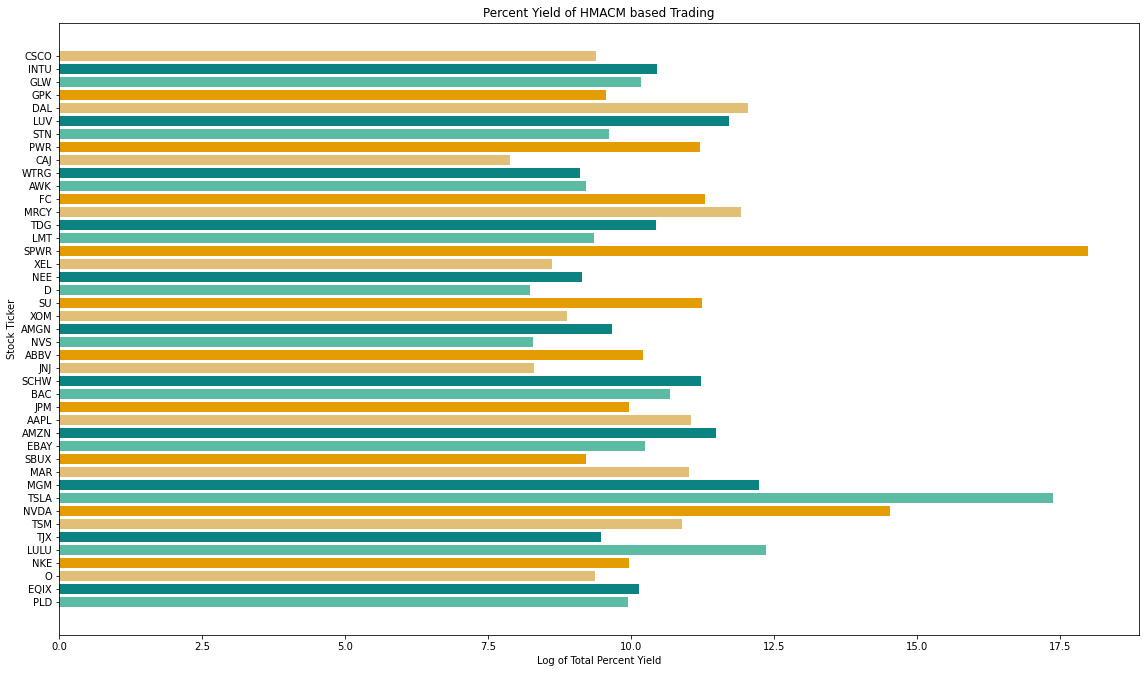

In [48]:
plt.rcParams["figure.figsize"] = (15,8.5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(stocks,np.log(yields),color=['#5CBBA3','#0B8383','#E2BF76','#E49C03'])
plt.xlabel('Log of Total Percent Yield')
plt.ylabel('Stock Ticker')
plt.title('Percent Yield of HMACM based Trading')
plt.show()

In [49]:
yields3 = list(((pred_yield_df.iloc[-1].values -pred_yield_df.iloc[0].values) / pred_yield_df.iloc[0].values)*100)

yields2 = list(((ob_yield_df.iloc[-1].values -ob_yield_df.iloc[0].values) / ob_yield_df.iloc[0].values)*100)

In [50]:
for y,s in enumerate(stocks):
    
    print(str(s) + ': ' + str(round(yields3[y] - bhyields[y],3))+'%')

PLD: 20414.222%
EQIX: 25260.249%
O: 11693.846%
NKE: 21005.706%
LULU: 234533.596%
TJX: 12853.3%
TSM: 53048.138%
NVDA: 2041891.697%
TSLA: 35366977.281%
MGM: 208477.363%
MAR: 60923.552%
SBUX: 9776.119%
EBAY: 28181.014%
AMZN: 97309.063%
AAPL: 62768.967%
JPM: 20954.76%
BAC: 43084.949%
SCHW: 74722.398%
JNJ: 3858.011%
ABBV: 26744.023%
NVS: 3858.25%
AMGN: 15570.586%
XOM: 7205.026%
SU: 77103.389%
D: 3693.146%
NEE: 8930.496%
XEL: 5291.49%
SPWR: 64866786.828%
LMT: 11157.887%
TDG: 33312.776%
MRCY: 150531.261%
FC: 80000.101%
AWK: 9699.849%
WTRG: 8937.78%
CAJ: 2710.668%
PWR: 73071.563%
STN: 14714.151%
LUV: 122160.416%
DAL: 170087.327%
GPK: 13874.824%
GLW: 25898.944%
INTU: 34340.433%
CSCO: 11629.91%


Basic Strategy Outperforms standard buying and holding by a lot!

Year Over Year gains below

In [51]:
for y,s in enumerate(stocks):
    print(str(s) + ': ' + str(round((pred_yield_df[str(s)+' Predicted Outcome'].iloc[-1] / 10000)**(1/10)*100 -100 , 2))+'%')

PLD: 70.66%
EQIX: 74.22%
O: 61.36%
NKE: 71.13%
LULU: 117.33%
TJX: 62.93%
TSM: 87.54%
NVDA: 169.86%
TSLA: 258.56%
MGM: 114.77%
MAR: 90.03%
SBUX: 58.46%
EBAY: 75.95%
AMZN: 99.21%
AAPL: 90.7%
JPM: 71.01%
BAC: 83.65%
SCHW: 93.95%
JNJ: 45.28%
ABBV: 75.28%
NVS: 44.96%
AMGN: 66.09%
XOM: 53.71%
SU: 94.44%
D: 44.26%
NEE: 57.71%
XEL: 49.6%
SPWR: 280.23%
LMT: 61.1%
TDG: 79.12%
MRCY: 107.83%
FC: 95.26%
AWK: 58.79%
WTRG: 57.22%
CAJ: 39.44%
PWR: 93.08%
STN: 65.14%
LUV: 104.03%
DAL: 111.19%
GPK: 64.3%
GLW: 74.39%
INTU: 79.73%
CSCO: 61.42%


In [52]:
yoy_yields = round((pred_yield_df.iloc[-1] / 10000)**(1/10)*100 -100 , 2)

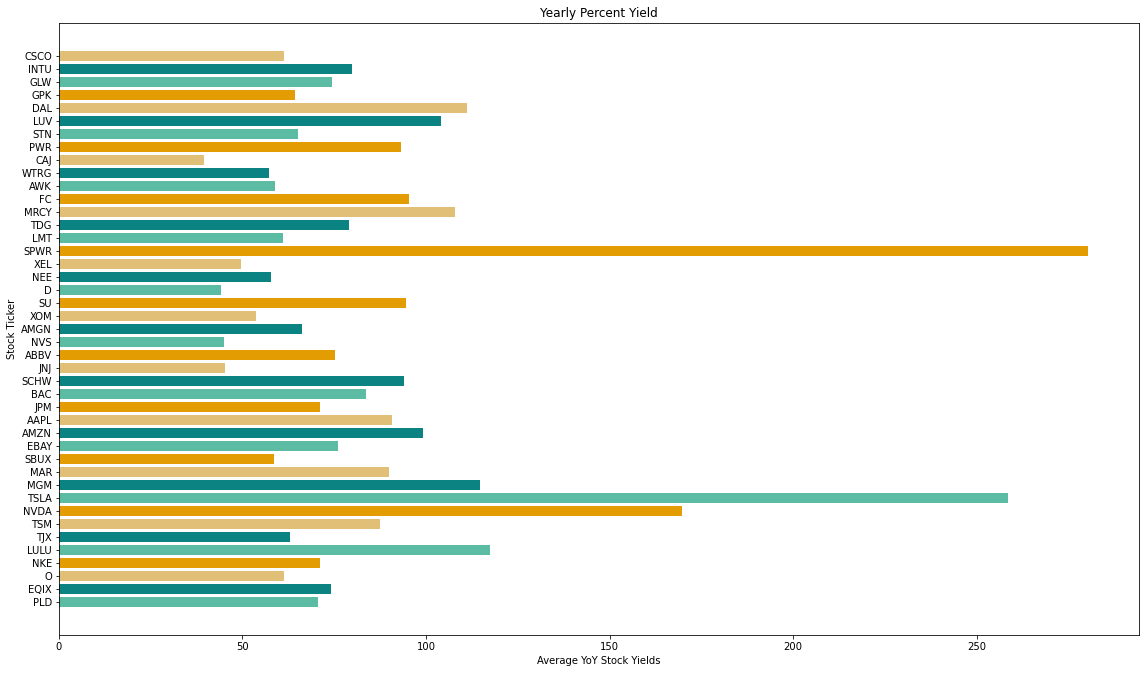

In [53]:
plt.rcParams["figure.figsize"] = (15,8.5)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(stocks,(yoy_yields),color=['#5CBBA3','#0B8383','#E2BF76','#E49C03'])
plt.xlabel('Average YoY Stock Yields')
plt.ylabel('Stock Ticker')
plt.title('Yearly Percent Yield')
plt.show()

#### Overfitting test

In [54]:
%%capture
stocks = ['GME','AMC']
# Creation of data, closing price of stock is retrieved
stock_list = []
for stock in stocks:
    df = yf.download(stock , period="10y", interval="1d");
    df.dropna(inplace=True);
    stock_list.append(df['Adj Close']);

data = pd.concat(stock_list, axis = 1)
data.columns = stocks

# Creation of daily percent changes data 1.0 = 0 % change
data_percentage = data.pct_change()

data_percentage = data_percentage.fillna(0)

data_percentage = data_percentage + 1

# Preserving Day of Week Data
dayofweek = []
for x in data_percentage.index:
    t = pd.Timestamp(x)
    dayofweek.append(t.date().weekday())
data_percentage.insert(len(data_percentage.columns),"day", dayofweek, True)

stock_data = concavity_maker(stocks)

In [55]:
stock_data['GME']

,price,support,pct_change,+/-,pct_change support,+/- support,important_connections support,underlying_stock,phase support,important_connections,...,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,volatility_bbp_before,trend_macd before,trend_kst_diff before,momentum_stoch_rsi_k before,momentum_ppo_hist before
0,15.50469,16.62428,0.000000,0,0.000000,0,16.62428,15.804863,3,15.50469,...,-1.553926,15.885489,-0.739135,-0.741880,43.345930,NaN,NaN,NaN,NaN,NaN
1,16.67406,16.50796,0.075420,1,-0.006997,-1,16.53166,16.337919,3,15.85411,...,-2.619289,15.900720,3.372736,3.317106,48.180610,0.466968,0.333119,-11.037298,0.138535,-0.507622
2,16.84757,16.41573,0.010406,1,-0.005587,-1,16.43905,16.483297,3,16.20354,...,-0.824828,15.927555,0.889820,0.885885,49.499151,0.768481,0.339204,-15.650226,0.197064,-0.380833
3,16.55296,16.34643,-0.017487,-1,-0.004222,-1,16.34643,16.420996,3,16.55296,...,-0.989750,15.934572,-0.377968,-0.378684,48.934091,0.923764,0.351703,-16.426108,0.441037,-0.247720
4,16.12775,16.29891,-0.025688,-1,-0.002907,-1,16.31915,16.559452,3,16.22626,...,-2.531841,15.966846,0.843167,0.839632,50.189854,0.844849,0.352517,-18.919083,0.651243,-0.199825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,144.02924,137.79271,0.048048,1,-0.005093,-1,137.79271,141.639999,4,144.02924,...,5.151614,126.035425,3.994128,3.916425,1184.637362,0.686940,2.586006,-10.019382,0.868889,0.650536
2443,149.86955,136.72271,0.040549,1,-0.007765,-1,136.32895,146.639999,4,145.12347,...,3.068304,127.932632,3.530076,3.469198,1229.986040,0.835306,3.184112,-7.410615,0.900762,0.876880
2444,152.33681,135.26623,0.016463,1,-0.010653,-1,134.86519,151.699997,4,146.21769,...,2.449251,131.334079,3.450626,3.392427,1275.878881,0.932327,4.015288,-6.625232,0.900762,1.189614
2445,147.31192,133.40143,-0.032985,-1,-0.013786,-1,133.40143,158.750000,4,147.31192,...,1.221207,136.871757,4.647332,4.542577,1339.820546,0.999818,5.024383,2.059674,0.985401,1.531676


In [56]:
Simv1('GME',10000)

,predicted_outcome,observed_outcome
0,1.000000e+04,1.000000e+04
1,1.000000e+04,1.000000e+04
2,1.044324e+04,1.044324e+04
3,1.052013e+04,1.052013e+04
4,1.061963e+04,1.061963e+04
...,...,...
2436,7.221963e+09,1.646434e+10
2437,7.476904e+09,1.704554e+10
2438,7.734904e+09,1.763372e+10
2439,8.094371e+09,1.845322e+10


In [57]:
pred_yield_df = pd.DataFrame()
ob_yield_df = pd.DataFrame()
pred_yield(stocks)
ob_yield(stocks)

In [58]:
for y,s in enumerate(stocks):
    print(str(s) + ': ' + str(round((pred_yield_df[str(s)+' Predicted Outcome'].iloc[-1] / 10000)**(1/10)*100 -100 , 2))+'%')

GME: 289.78%
AMC: 218.15%


In [59]:
yields3 = list(((pred_yield_df.iloc[-1].values -pred_yield_df.iloc[0].values) / pred_yield_df.iloc[0].values)*100)

yields2 = list(((ob_yield_df.iloc[-1].values -ob_yield_df.iloc[0].values) / ob_yield_df.iloc[0].values)*100)

for y,s in enumerate(stocks):
    
    print(str(s) + ': ' + str(round(yields3[y],3))+'%')
    
#CLF still works with other stock data, overfitting isn't necessarily a problem since most variables account for 
#different aspects of one single variable, the phase before...

GME: 80943609.232%
AMC: 10624078.0%
